# Parameterizing Vertical Mixing Coefficients in the Ocean Surface Boundary Layer Using Neural Networks


In this notebook, we reproduce a portion of the analysis carried out by\
**Sane et al. (2023) "Parameterizing vertical mixing coefficients in the ocean surface boundary layer using neural networks." Journal of Advances in Modeling Earth Systems 15.10: [e2023MS003890](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2023MS003890)** (with original code and data at https://zenodo.org/records/8293998)

### Tasks Covered Here
- **Data Processing and Preparation**: Reading and filtering output from the Generalized Ocean Turbulence Model (GOTM) (GOTM is section 3.3 of Sane et al. 2023).
- **Neural Network Training**: Implementing neural networks to predict shape function $ g(\sigma) $ based on input physical parameters ($ \mathcal{N}_1 $.).
- **Hyperparameter Optimization**: Conducting a hyperparameter sweep to evaluate the effect of different model architectures (e.g., number of layers, nodes) on performance.
- **Model Evaluation and Visualization**: Analyzing the ML model skill using training/validation loss
- **Visualizing results**: Reproducing Figures 1-4 of Sane et al. 2023.
  
### Estimated Compute Time
- On LEAP Pangeo GPU configuration in February 2025, this notebook should run to completion in ~10 minutes
- This notebook will take several hours on LEAP-Pangeo education CPU configuration (4 CPU, 32GB RAM). 
- Options for speed up include lowering patience to triggering faster early stopping or further limiting hyperparameter sweep. 

### Collaboration Guidelines for Climate Prediction Challenges with Machine Learning (Spring 2025), Columbia University Earth and Environmental Sciences and Statistics
- GitHub sharing is recommended. 
  - We have prepared a [Github Tutorial](https://github.com/leap-stc/LEAPCourse-Climate-Pred-Challenges/blob/main/Tutorials/Github-Tutorial.md) to help. 
  - If this is not working for you, please reach out with questions.

# 1. Setup workspace and Import packages

In [5]:
%%capture
import importlib

# Check and install torch
if importlib.util.find_spec("torch") is None:
    !pip install torch

# Check and install zarr
if importlib.util.find_spec("zarr") is None:
    !pip install zarr

# Ensure xarray is upgraded
!pip install --upgrade xarray


In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import copy as copy
import matplotlib as mpl
import netCDF4 as ncd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as Data
from torch import nn, optim
import matplotlib.cm as cm
import copy as copy
import multiprocessing as mp
from scipy import stats
import time as time
import matplotlib.font_manager
import seaborn as sns
import pandas as pd
from tqdm import tqdm  # Import tqdm for the progress bar
import xarray as xr
import requests

from datetime import datetime
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

today = datetime.today()
torch.cuda.empty_cache()

cwd=os.getcwd()
parent_dir = os.path.dirname(cwd)
os.chdir(parent_dir)
cwd = parent_dir
print("Current working directory:", os.getcwd())

# custom modules
import lib.func_file as ff
from lib.visual_figure4 import performance_sigma_point
from lib.visual_figure3 import score_eval, save_losses_by_seed, plot_n1_scores

np.random.seed(100)

cwd_data = cwd + '/data/'
## 
cwd_output = cwd + '/output/'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Current working directory: /home/jovyan/dhruv/LEAPCourse-Climate-Pred-Challenges/Project-StarterCodes/Project2-Parameterization


# 2. Introduction


Vertical mixing in the ocean surface boundary layer (OSBL) plays a vital role in regulating the exchange of heat, momentum, and carbon between the atmosphere and the ocean interior. As a key determinant in the rate of ocean heat uptake, the OBSL plays a central role in the ocean's modulation of global air temperatures and in the sea level rise that results from a warming ocean. The OBSL also modulates the rate the ocean absorbs anthropogenic CO$_2$, thus playing a key role in the ocean's modulation atmospheric CO$_2$ levels, and thus, on climate change. If these processes are to be confidently projected for the future, it is critical that the OBSL be accurately represented in ocean models and the ocean components of Earth System Models.  

In sum, accurate parameterization of upper ocean vertical mixing is a critical component of ocean and climate modeling.  

Upper ocean vertical mixing typically represented as a vertically-varying diffusivity parameter $ \kappa_\phi (\sigma) $, where $\kappa$ is a variable diffisivity of scalar $\phi$, and $\sigma$ is a vertical index scaled to the depth of the upper ocean mixed layer.

Traditionally, vertical diffusivity is parameterized using **universal shape functions**, such as the dashed line shown in the first figure below. These fixed, predefined profiles assume uniformity across diverse ocean conditions. However, as illustrated in Figure 1, shape functions derived from more sophisticated, but more computationally expensive, second moment closure (SMC) methods (blue shaded region) demonstrate significant variability under different forcing conditions. The discrepancy between the universal shape function and SMC-derived profiles highlights a fundamental limitation: universal functions fail to capture the dynamic, environment-dependent behavior of vertical mixing in the OBSL.

This deficiency motivates the need for a more adaptive and accurate approach. Sane et al. (2023) propose a **neural network-based model** to replace the universal shape function. Neural networks offer the flexibility to learn complex, nonlinear relationships from data and can dynamically adjust the shape function to reflect varying physical conditions. This data-driven, physics-aware method bridges the gap between traditional parameterization schemes and the variability observed in high-fidelity SMC models. Though not the focus here, the approach of Sane et al. (2023) is also designed for seamless integration and computational efficiency in existing global ocean model codes; the impacts of this implementation is illustrated in section 4 of the paper. 

The approach integrates two neural networks:

1. $ \mathcal{N}_1 $: Predicts the shape function $ g(\sigma) $, capturing the vertical structure of diffusivity.
2. $ \mathcal{N}_2 $: Predicts the velocity scale $ v_0 $, which, combined with $ g(\sigma) $, yields the full diffusivity profile.

By leveraging neural networks, the authors aim to enhance the accuracy and generalizability of vertical mixing parameterizations in OGCMs, enabling more reliable ocean and climate predictions.

Here, we will focus on predicting the shape function $ g(\sigma) $ for vertical diffusivity using the neural network  $ \mathcal{N}_1 $.

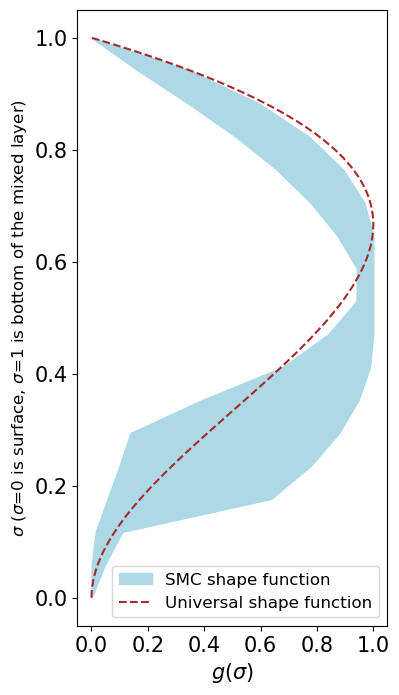

In [7]:
# Load GOTM training data produced by Sane et al. 2023
# Plot the assumed univeral shape function vs. GOTM results to illustrate the qualitative differences

store = 'https://nyu1.osn.mghpcc.org/leap-pangeo-manual/GOTM/raw_training_data.zarr'
d = xr.open_dataset(store, engine='zarr', chunks={})

h=d['h'][:]
h_ind1=np.where(h>10)[0]
h_ind2=np.where(h<700)[0]
h_ind=np.intersect1d(h_ind1,h_ind2)
sf1=d['SF'][h_ind,:]
sf1=sf1[237945:237945+5000,:] # randomly selected few profiles.

sf=np.zeros([len(sf1),16])

sf1 = sf1.values if hasattr(sf1, "values") else sf1
sf = sf1 / np.max(sf1, axis=1, keepdims=True)

# define vertical coordinate
sig=np.linspace(0,1,18)

# define universal shape function, section 2
# gamma = 2
z=np.linspace(0,1,100)
z1=z*(1-z)**2
z1=z1/np.max(z1)

sfmin=np.zeros(18)
sfmax=np.zeros(18)
sfmin[1:17]=np.min(sf,axis=0)
sfmax[1:17]=np.max(sf,axis=0)

plt.figure(figsize=(4,8))
#plt.plot(sfmin,sig,'o')
#plt.plot(sfmax,sig,'o')
plt.fill_betweenx(sig,sfmin,sfmax,color='lightblue',label='SMC shape function')
plt.plot(z1[::-1],z,color='brown',linestyle='--',label='Universal shape function')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'$g(\sigma)$',fontsize=15)
plt.ylabel(r'$\sigma$ ($\sigma$=0 is surface, $\sigma$=1 is bottom of the mixed layer)',fontsize=12)
plt.legend(fontsize=12)

Remember, profiles are plotted upside down 
- $\sigma$=1 is BOTTOM of the column
- $\sigma$=0 is TOP of the column

# 2. Data 

## 2.1 Dataset Description

### Overview of Data Generation
The training data for $ \mathcal{N}_1 $ is derived from outputs of the **General Ocean Turbulence Model (GOTM)** (Umlauf & Burchard, 2005; Umlauf et al. 2014). GOTM is a one-dimensional water column model designed for simulating vertical turbulent mixing processes in the ocean. It provides a flexible and modular framework for testing turbulence parameterizations and studying oceanic boundary layer dynamics. GOTM is widely used in oceanography and climate research to investigate turbulence fluxes and vertical diffusivity.

For more information, documentation, and source code, visit the official GOTM website: [GOTM Homepage](https://gotm.net)

GOTM calculates upper ocean turbulence directly and from these vertical diffusivity outputs, the shape function $g(\sigma)$ we require can be derived. 

---

In this project, we use the pre-processed GOTM dataset from([zenodo link for Sane et al. 2023](https://zenodo.org/records/8293998)). This dataset contains all necessary variables for training $ \mathcal{N}_1 $. We do not run GOTM here. 

The dataset includes the following variables:

- **l0 (Coriolis parameter)**: Coriolis parameter, calculated based on latitude. Typically called $f$. Units of 1/s.
- **b0 (Surface Buoyancy Flux)**: Represents buoyancy flux at the surface. Units of m$^2$/s$^3$
- **ustar0 (Surface Friction Velocity)**: Surface friction velocity, related to wind shear. Units of m/s.
- **h0 (Boundary Layer Depth)**: The depth of the boundary layer in the ocean or atmosphere. Units of m.
- **lat0 (Latitude)**: Geographical latitude in degrees. 
- **heat0 (Surface Heat Flux)**: Heat flux at the surface, measured in W/m².
- **tx0 (Wind Stress)**: Surface wind stress, measured in N/m².
- **Shape Function ($ \text{SF} $)**: The normalized diffusivity profile ($ g(\sigma) $).


In [8]:
# Open the dataset from Sane et al. 2023, here stored on the cloud, accessible on LEAP-Pangeo
store = 'https://nyu1.osn.mghpcc.org/leap-pangeo-manual/GOTM/sf_training_data.zarr'
d = xr.open_dataset(store, engine='zarr', chunks={})

# this function calculates the coriolis parameter from input latitude 
# 2*Omega*sin(lat), where Omega is the Earth's rotation in 1/s
def corio(lat):
    return  2*(2*np.pi/(24*60*60)) * np.sin(lat*(np.pi/180))

l0=corio(d['l'][:])
b00=d['b0'][:]
ustar0=d['ustar'][:]
h0=d['h'][:]
lat0=d['lat'][:]
heat0=d['heat'][:]
tx0=d['tx'][:] 
tx0=np.round(tx0,2)
SF0=d['SF'][:] 


## 2.2 Visualization

It is important to understand your data. Here we make plots of the input and output data to understand their distributions

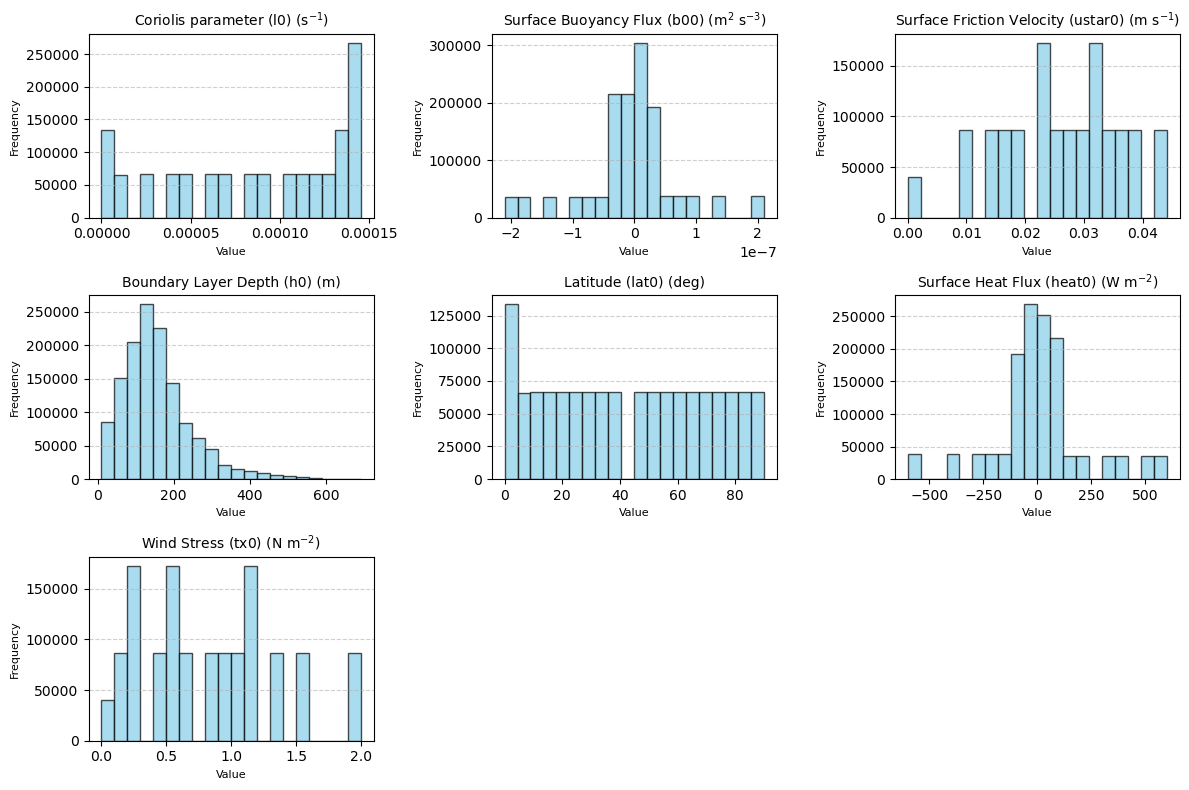

In [9]:
variables = {
    "Coriolis parameter (l0) (s$^{-1}$)": l0.values.flatten(),
    "Surface Buoyancy Flux (b00) (m$^{2}$ s$^{-3}$)": b00.values.flatten(),
    "Surface Friction Velocity (ustar0) (m s$^{-1}$)": ustar0.values.flatten(),
    "Boundary Layer Depth (h0) (m)": h0.values.flatten(),
    "Latitude (lat0) (deg)": lat0.values.flatten(),
    "Surface Heat Flux (heat0) (W m$^{-2}$)": heat0.values.flatten(),
    "Wind Stress (tx0) (N m$^{-2}$)": tx0.values.flatten(),
}

# Plot histograms for the input variables
plt.figure(figsize=(12, 8))
for i, (name, data) in enumerate(variables.items()):
    plt.subplot(3, 3, i + 1)
    plt.hist(data, bins=20, color="skyblue", edgecolor="black", alpha=0.7)
    plt.title(name, fontsize=10)
    plt.xlabel("Value", fontsize=8)
    plt.ylabel("Frequency", fontsize=8)
    plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

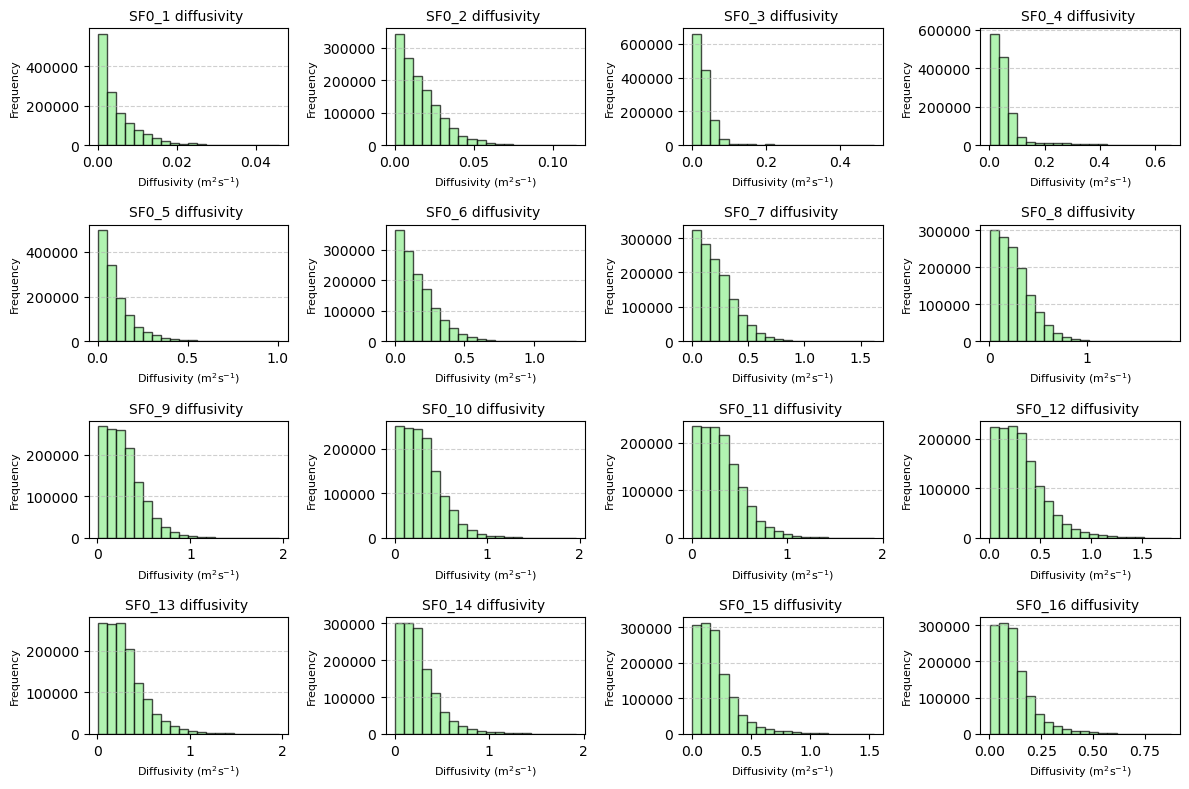

In [10]:
# Plot histograms of the distribution of vertical diffusivity (SF0) at each level from GOTM
#
# SF0_1 is adjacent to the BOTTOM of the OBSL - note small diffusivity values here (0-0.04)
# SF0_16 is TOP of the column - note greater diffusivity values here (0-0.75)
#
# Note that diffusivity ranges in each layer differ by 2 orders of magnitude

plt.figure(figsize=(12, 8))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.hist(SF0[:, i].values.flatten(), bins=20, color="lightgreen", edgecolor="black", alpha=0.7)
    plt.title(f"SF0_{i + 1} diffusivity ", fontsize=10)
    plt.xlabel("Diffusivity (m$^2$s$^{-1}$)", fontsize=8)
    plt.ylabel("Frequency", fontsize=8)
    plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

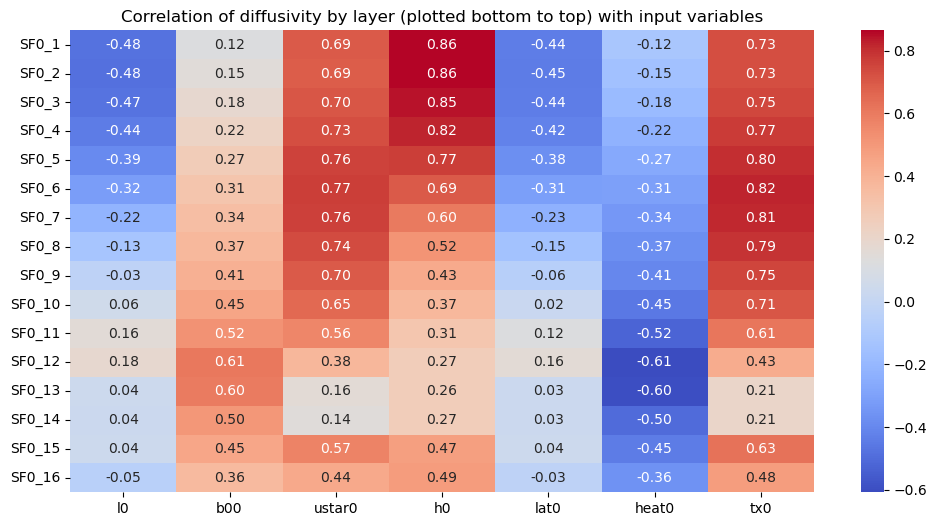

In [11]:
# How are the input data correlated to diffusivity at each level? Make a plot to consider this
data = {
    "l0": l0.values.flatten(),
    "b00": b00.values.flatten(),
    "ustar0": ustar0.values.flatten(),
    "h0": h0.values.flatten(),
    "lat0": lat0.values.flatten(),
    "heat0": heat0.values.flatten(),
    "tx0": tx0.values.flatten(),
}

for i in range(16):
    data[f"SF0_{i+1}"] = SF0[:, 16-i-1].values.flatten()

df = pd.DataFrame(data)

correlation_matrix = df.corr()

sf0_correlation = correlation_matrix.loc["SF0_1":"SF0_16", ["l0", "b00", "ustar0", "h0", "lat0", "heat0", "tx0"]]

plt.figure(figsize=(12, 6))
sns.heatmap(sf0_correlation, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Correlation of diffusivity by layer (plotted bottom to top) with input variables")
plt.show()


### Correlations with Input variables

Recall 
- SF0_1 is adjacent to BOTTOM of OBSL
- SF0_16 is adjacent to TOP of OBSL
- $\sigma = \frac{z}{h}$ is a normalized vertical coordinate, so the $\it{physical}$ depth of the OBSL is variable across the ocean (from a few meters in the lower latitudes and in summer at mid-latitudes, to 100s m in the mid-latitude winter, to >1000 m at high latitudes in winter)

The correlation between SF0 at each level and the input variables varies across depths. For example, buoyancy flux (b00) is more correlated with diffusivity higher in the column but measures of wind (ustar0, tx0) are more correlated with diffuivity nearer to the bottom of the OBSL. 

Keep in mind the variation in magnitudes of diffusivity from the plot above. 

## 2.3 Data Filtering
To ensure high-quality and valid data for training, specific filtering criteria are applied by Sane et al. (2023):

1. Heat flux ($ \text{heat} $) magnitude below 601 $ W/m^2 $.
2. Wind stress ($ \text{tx} $) below 1.2 $ N/m^2 $.
3. Boundary layer depth ($ \text{h} $) between 30 m and 300 m.

In [12]:
# Apply the constraints defined above
ind101=np.where(np.abs(heat0)<601)[0]
ind1=ind101 
ind2=np.where(tx0<1.2)[0]
ind3=np.where(h0>29)[0]
ind4=np.where(h0<301)[0]
# Filter the data to only those that obey the constraints
# ind7 is the final filter to indentify the data that will be input to N1 training
ind5=np.intersect1d(ind1,ind2)
ind6=np.intersect1d(ind3,ind5)
ind7=np.intersect1d(ind4,ind6) 

In [13]:
# there are 16 levels (1 at bottom, 16 at top)
mm1=0; mm2=16  #0; 16
# apply ind7 to keep only the profiles that meet the filtering criteria
# Training uses only 4 inputs: Coriolis parameter (l0), buoyancy flux (b00), surface friction velocity (ustar0) and boundary layer depth (h0)
data_load_main=np.zeros([len(h0[ind7]),4+mm2-mm1])
data_load_main[:,0]=l0[ind7]
data_load_main[:,1]=b00[ind7]
data_load_main[:,2]=ustar0[ind7]
data_load_main[:,3]=h0[ind7]
data_load_main[:,4:(mm2-mm1+4)]=SF0[ind7,mm1:mm2]

data_forc=np.zeros([len(ind7),3])
data_forc[:,0]=lat0[ind7]
data_forc[:,1]=heat0[ind7]
data_forc[:,2]=tx0[ind7]

data_load3=copy.deepcopy(data_load_main)

print('started')

data, x,y, stats, k_mean, k_std=ff.preprocess_train_data(data_load3)  
# Note: ff.preprocess_train_data is a custom function defined in lib/func_file.py that normalizes, log-transforms and shuffles the dataset


started


## 2.4 Validation Dataset

In this project, training and validation datasets are generated independently through separate simulations. This practice ensures **strict independence** between the two datasets, avoiding issues like **data leakage** or overfitting. 

In [14]:
# valid_data=np.loadtxt(cwd_data+'data_testing_4_paper.txt')[:,3:]

url = "https://nyu1.osn.mghpcc.org/leap-pangeo-manual/GOTM/data_testing_4_paper.txt"
df = pd.read_csv(url, delim_whitespace=True, header = None)  
valid_data = df.iloc[:, 3:].values 

ind3=np.where(valid_data[:,3]>29)[0]
ind4=np.where(valid_data[:,3]<301)[0]
ind=np.intersect1d(ind3,ind4)

valid_x=valid_data[ind,0:4]

valid_x[:,0]=(valid_x[:,0]-stats[0])/stats[1]
valid_x[:,1]=(valid_x[:,1]-stats[2])/stats[3]
valid_x[:,2]=(valid_x[:,2]-stats[4])/stats[5]
valid_x[:,3]=(valid_x[:,3]-stats[6])/stats[7]
k_mean_test=np.zeros(16)
valid_y=valid_data[ind,5:]

for i in range(len(valid_y)):
    valid_y[i,:]=np.log(valid_y[i,:]/np.max(valid_y[i,:]))

for i in range(16):
    valid_y[:,i]=(valid_y[:,i]-k_mean[i])/k_std[i]

In [15]:
x=torch.FloatTensor(x).to(device)
y=torch.FloatTensor(y).to(device)

valid_x=torch.FloatTensor(valid_x).to(device)
valid_y=torch.FloatTensor(valid_y).to(device)

# 3. Neural Network Architecture

The learnKappa_layers class is a neural network model built using PyTorch's nn.Module. It consists of three fully connected (linear) layers with ReLU activation and dropout for regularization. 

Define here a 2 hidden-layer model

In [16]:
class learnKappa_layers(nn.Module):
    def __init__(self, In_nodes, Hid, Out_nodes):
        super(learnKappa_layers, self).__init__()
        self.linear1 = nn.Linear(In_nodes, Hid)  # First layer: Input to hidden
        self.linear2 = nn.Linear(Hid, Hid)       # Second layer: Hidden to hidden
        self.linear3 = nn.Linear(Hid, Out_nodes) # Third layer: Hidden to output
        self.dropout = nn.Dropout(0.25)          # Dropout for regularization

    def forward(self, x):
        x2 = self.linear1(x)
        h1 = torch.relu(x2)            # ReLU activation for layer 1
        h1 = self.dropout(h1)          # Apply dropout
        
        h2 = self.linear2(h1)
        h3 = torch.relu(h2)            # ReLU activation for layer 2
        h3 = self.dropout(h3)          # Apply dropout

        y_pred = self.linear3(h3)      # Final output layer
        return y_pred


# 4. Model Training

The modeltrain_loss function trains a neural network model using PyTorch with a custom loss calculation and implements early stopping to prevent overfitting and save computing time.

Early Stopping: Stops training if the validation loss does not improve for patience consecutive epochs, saving the best model state. Increasing patience will further reduce loss, but lengthen runtime.

In [17]:
def modeltrain_loss(In_nodes, Hid, Out_nodes, lr, epochs, x, y, valid_x, valid_y, model, k_std_y, k_mean, k_std, patience=20):
    optimizer = torch.optim.Adam(model.parameters(), lr)  # Adam optimizer
    loss_fn = torch.nn.L1Loss(reduction='mean')  # L1 loss for gradient computation
    loss_array = torch.zeros([epochs, 3])  # Array to store epoch, train, and validation losses

    best_loss = float('inf')  # Initialize the best validation loss as infinity
    no_improvement = 0  # Counter for epochs without improvement
    best_model_state = None  # Placeholder for the best model state

    # Add a progress bar
    with tqdm(total=epochs, desc="Training Progress", unit="epoch") as pbar:
        for k in range(epochs):
            optimizer.zero_grad()  # Clear gradients from the previous step
            y_pred = model(x)  # Forward pass for training data
            
            valid_pred = model(valid_x)  # Forward pass for validation data
            
            # Loss used for gradient calculation
            loss = loss_fn(y_pred * k_std_y, y * k_std_y)
            
            loss_train = torch.mean(torch.abs(torch.exp(y_pred * k_std + k_mean) - torch.exp(y * k_std + k_mean)))
            loss_valid = torch.mean(torch.abs(torch.exp(valid_pred * k_std + k_mean) - torch.exp(valid_y * k_std + k_mean)))
            
            loss.backward()  # Backpropagate the gradient
            optimizer.step()  # Update model parameters

            # Record the losses for this epoch
            loss_array[k, 0] = k  
            loss_array[k, 1] = loss_train.item()  
            loss_array[k, 2] = loss_valid.item()  

            # Update the progress bar with the current epoch and losses
            pbar.set_postfix(
                train_loss=loss_train.item(), 
                valid_loss=loss_valid.item(), 
                patience_count=no_improvement
            )
            pbar.update(1)  # Increment the progress bar

            # Early stopping: Check if validation loss improves
            if loss_valid.item() < best_loss:
                best_loss = loss_valid.item()  # Update best loss
                no_improvement = 0
                best_model_state = model.state_dict()  
            else:
                no_improvement += 1  # Increment no improvement counter

            # If no improvement for 'patience' epochs, stop training
            if no_improvement >= patience:
                print(f"\nEarly stopping at epoch {k+1}. Validation loss has not improved for {patience} epochs.")
                break

            # Free memory by deleting intermediate variables
            del loss, y_pred
            
    # Restore the best model state after training
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return model, loss_array[:k, :]


In [18]:
# Loss weighting option here, all weights = 1.0 in default run 
# Weight settings here
kms1=1.0 
kms2=1.0
# Weight per node set here. Set weights to kms1 or to kms2 to use values above
k16 = kms1; k15 = kms1; k14 = kms1; k13 = kms1; k12 = kms1; k11 = kms1; 
k10 = kms1; k9 = kms1; k8 = kms1; k7 = kms1; k6 = kms1; k5 = kms1; 
k4 = kms1; k3 = kms1; k2 = kms1; k1 = kms1; 
# Weight for each layer. 
# ARRANGED FROM TOP (node = 16) TO BOTTOM (node = 1)
kmask=np.array([k16,k15,k14,k13,k12,k11,k10,k9,k8,k7,k6,k5,k4,k3,k2,k1])

In [19]:
# Train N1 for the first time!
epochs, k_points, lr=3000, 16, 1e-03
in_nod, hid_nod, o_nod = 4, 32, 16

torch.manual_seed(10)

k_mean_c=torch.tensor(k_mean).float().to(device)
k_std_c=torch.tensor(k_std).float().to(device)

model = learnKappa_layers(in_nod, hid_nod, o_nod)
model = model.to(device)
model, loss_array = modeltrain_loss(in_nod, hid_nod, o_nod, lr, epochs, x, y,valid_x,valid_y,model,torch.tensor(kmask).float().to(device), k_mean_c, k_std_c)

### in this version, there is no weighting in the loss function. This will be added in section 6. 

Training Progress:  26%|██▌       | 767/3000 [00:25<01:14, 29.83epoch/s, patience_count=19, train_loss=0.0387, valid_loss=0.0557]


Early stopping at epoch 767. Validation loss has not improved for 20 epochs.


# 5. Evaluation and Visualization

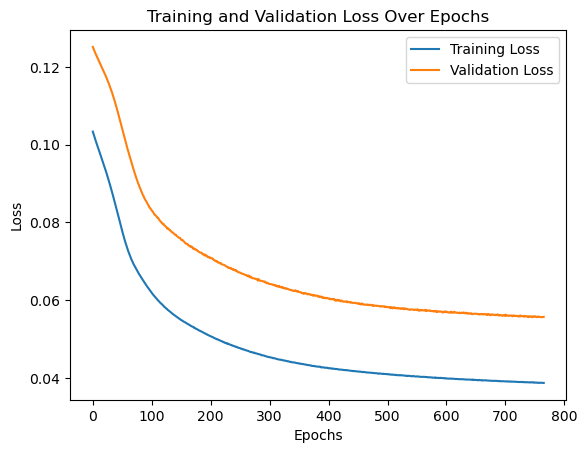

In [20]:
plt.plot(loss_array[:, 0], loss_array[:, 1], label="Training Loss")
plt.plot(loss_array[:, 0], loss_array[:, 2], label="Validation Loss")

# Adding labels and title
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")

# Adding a legend
plt.legend()

# Displaying the plot
plt.show()


### Reproduce here Figure 4 of Sane et al (2023) using a function defined in /lib/visual_figure4.py
As in the training data from GOTM
- Node 1 is adjacent to BOTTOM of OBSL
- Node 16 is adjacent to TOP of OBSL 

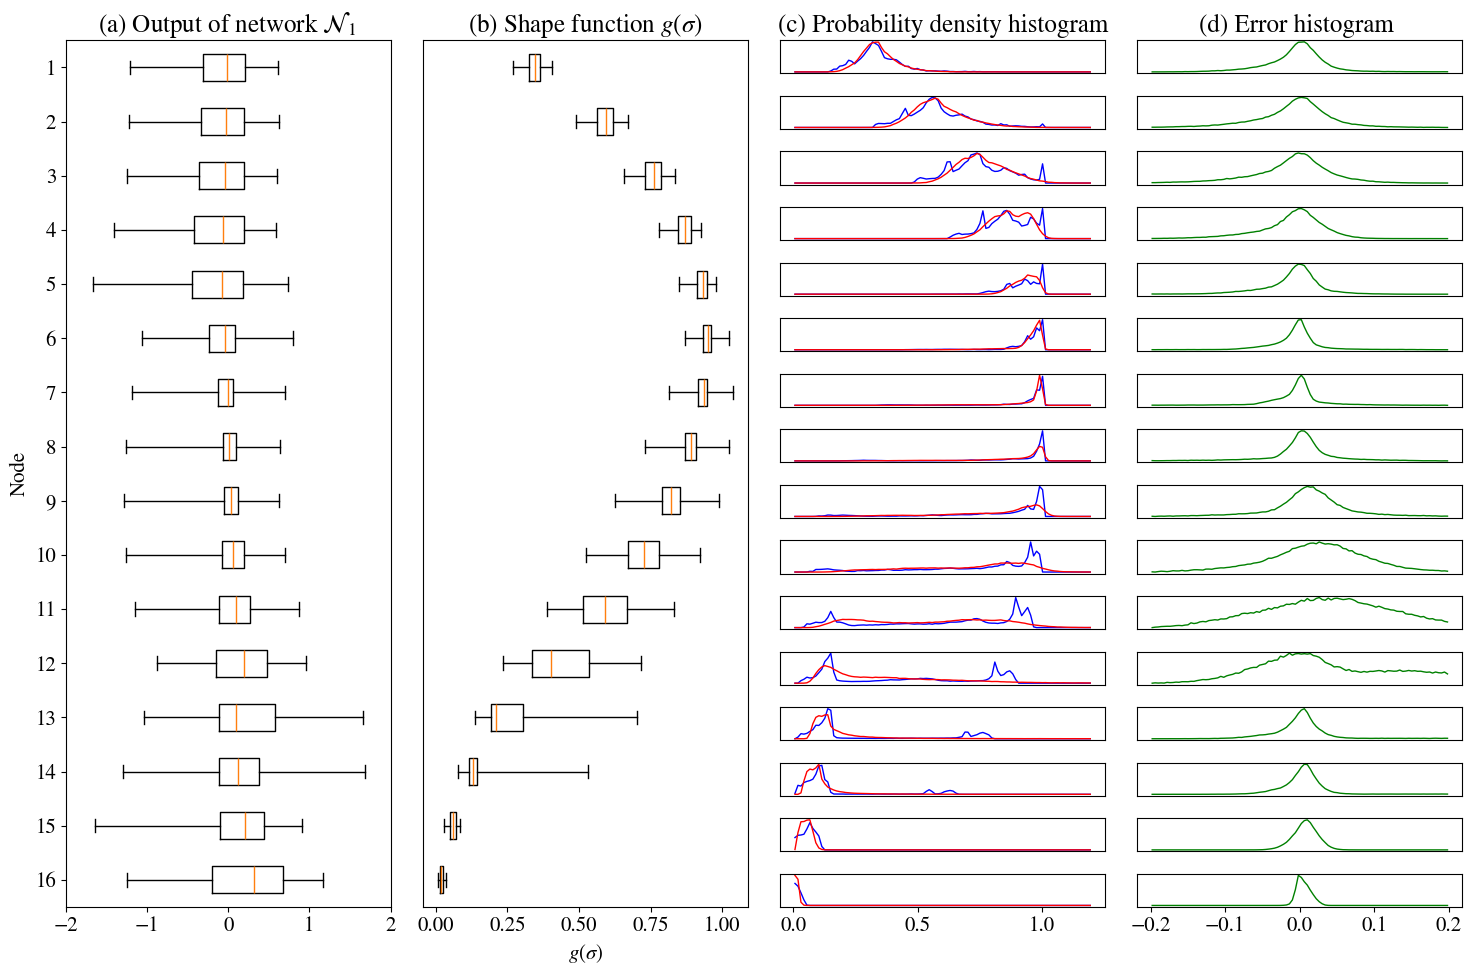

In [17]:
performance_sigma_point(model, x, valid_x, y, valid_y, k_mean, k_std)

# 6. Further Exploration

## 6.1 Modifying Loss Function with Node-Specific Weighting

As discussed at the end of section 3.4 of Sane et al. (2023), we adjust the training process by modifying the loss function to prioritize nodes with higher variance. Key steps and configurations:

**Node-Specific Weighting**: We applied node-specific weights (`kmask`) to amplify the loss values for nodes 8 to 13 by a factor of 100 (`kms2 = 100.0`), while keeping the weight at other nodes as 1.0 (`kms1 = 1.0`). 

This approach helps focus the model on reducing errors for nodes with higher variance, making them easier to learn.

In [18]:
# Loss weighting option here 
# Weight settings here
kms1=1.0 
kms2=100.0
# Weight per node set here. Set weights to kms1 or to kms2 to use values above
k16 = kms1; k15 = kms1; k14 = kms1; k13 = kms2; k12 = kms2; k11 = kms2; 
k10 = kms2; k9 = kms2; k8 = kms2; k7 = kms1; k6 = kms1; k5 = kms1; 
k4 = kms1; k3 = kms1; k2 = kms1; k1 = kms1; 
# Weight for each layer. 
# ARRANGED FROM TOP (node = 16) TO BOTTOM (node = 1)
kmask=np.array([k16,k15,k14,k13,k12,k11,k10,k9,k8,k7,k6,k5,k4,k3,k2,k1])

In [19]:
epochs, k_points, lr=3000, 16, 1e-03

# Loss weighting implemented here
in_nod, hid_nod, o_nod = 4, 32, 16

torch.manual_seed(10)

k_mean_c=torch.tensor(k_mean).float().to(device)
k_std_c=torch.tensor(k_std).float().to(device)

model = learnKappa_layers(in_nod, hid_nod, o_nod)
model = model.to(device)
model, loss_array = modeltrain_loss(in_nod, hid_nod, o_nod, lr, epochs, x, y,valid_x,valid_y,model,torch.tensor(kmask).float().to(device), k_mean_c, k_std_c)


Training Progress:  38%|███▊      | 1132/3000 [00:37<01:02, 29.79epoch/s, patience_count=19, train_loss=0.0363, valid_loss=0.0535]


Early stopping at epoch 1132. Validation loss has not improved for 20 epochs.


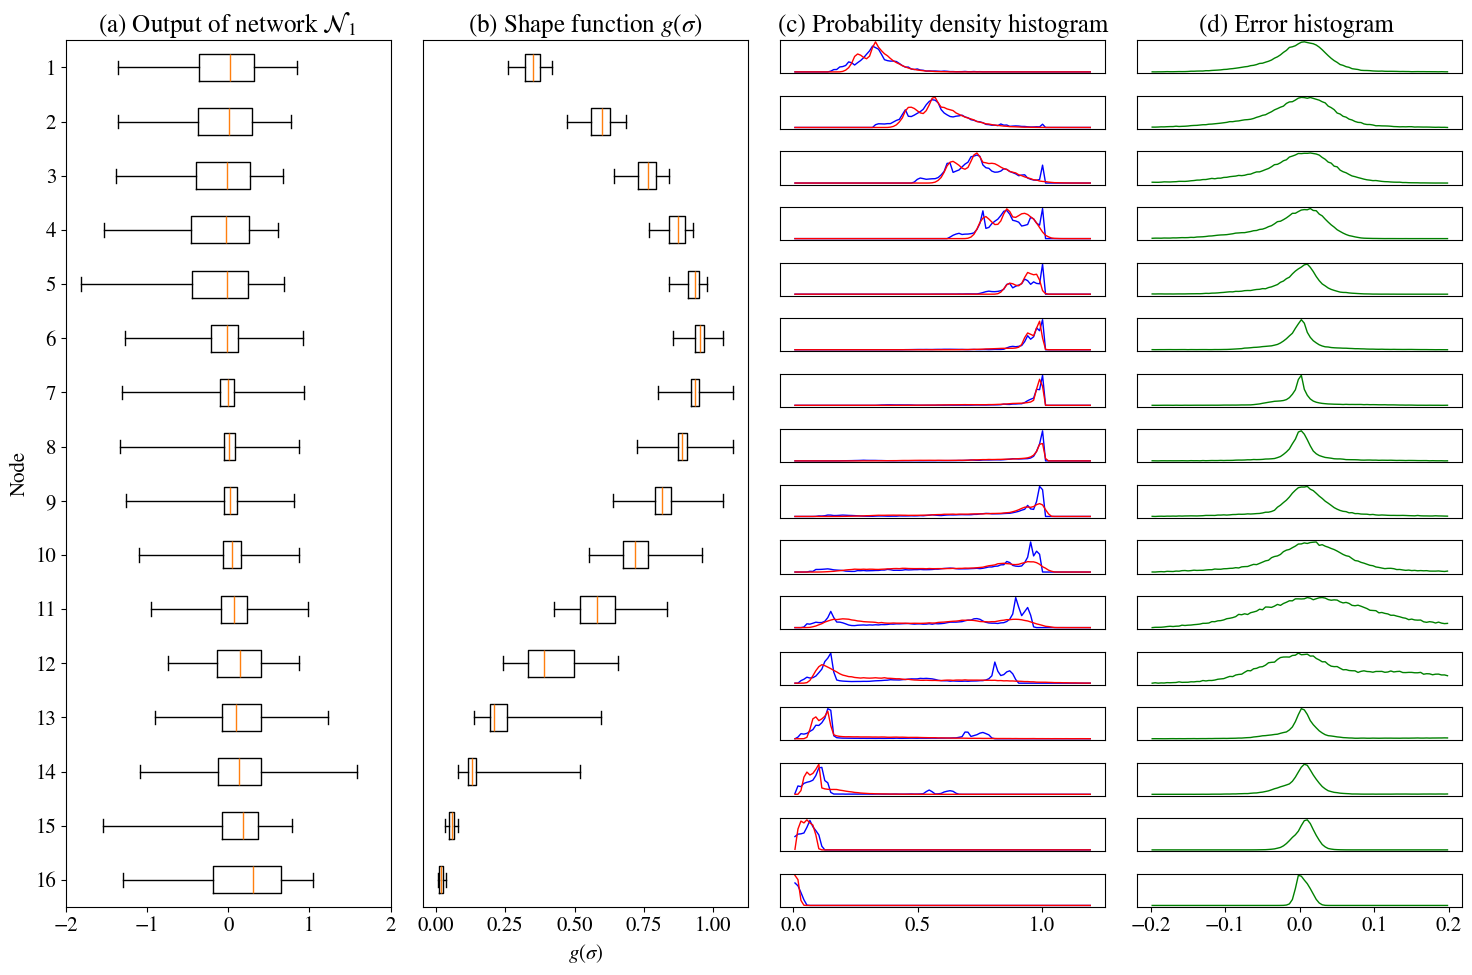

In [20]:
performance_sigma_point(model, x, valid_x, y, valid_y, k_mean, k_std)

#### You will have to look closely to find differences from the unweighted training!

## 6.2 Hyperparameter Sweep for Network Architecture

In this section, we conducted a hyperparameter sweep to evaluate the performance of different neural network architectures by varying:
- The **number of layers**.
- The **number of hidden nodes per layer**.

#### Parameter Count Calculation
The number of trainable parameters for a given architecture is calculated as:
$$
P = \sum_{l=1}^{L} \big( n_{\text{input}, l} \times n_{\text{output}, l} + n_{\text{output}, l} \big)
$$
Where:
- $ n_{\text{input}, l} $: Number of input nodes to layer $l $.
- $ n_{\text{output}, l} $: Number of output nodes from layer $ l$.

Using a **4-core CPU with 32GB RAM**, the estimated computational time for training all models with the above configurations is many hours. 

- **We recommend using a GPU server.**  

- In addition, limit sweep to **1-2 layers** and **2-64 hidden nodes** per layer. This enables a much faster, but still meaningful evaluation of the model's depth and width.


In [21]:
# Loss weighting option here, all weights = 1.0 in hyperparameter sweep
# Weight settings here
kms1=1.0 
kms2=1.0
# Weight per node set here. Set weights to kms1 or to kms2 to use values above
k16 = kms1; k15 = kms1; k14 = kms1; k13 = kms1; k12 = kms1; k11 = kms1; 
k10 = kms1; k9 = kms1; k8 = kms1; k7 = kms1; k6 = kms1; k5 = kms1; 
k4 = kms1; k3 = kms1; k2 = kms1; k1 = kms1; 
# Weight for each layer. 
# ARRANGED FROM TOP (node = 16) TO BOTTOM (node = 1)
kmask=np.array([k16,k15,k14,k13,k12,k11,k10,k9,k8,k7,k6,k5,k4,k3,k2,k1])

In [22]:
## We perform hyper-parameter sweep in this section.

epochs, k_points, lr=3000, 16, 1e-03

hid_array=np.array([2,4,8,16,32,64])

lays = np.array([1,2])

torch.manual_seed(10)

k_mean_c=torch.tensor(k_mean).float().to(device)
k_std_c=torch.tensor(k_std).float().to(device)

first_print_done = False  # Ensure the success message prints only once

for la in lays:
    cwd_sd = cwd_output + 'ensemble_models_layers' + str(la) + '/'

    for h in hid_array:
        in_nod, hid_nod, o_nod = 4, h, 16
        print('la, h is >', la, h)

        if la == 1:
            model = ff.learnKappa_layers1(in_nod, hid_nod, o_nod)
        elif la == 2:
            model = ff.learnKappa_layers2(in_nod, hid_nod, o_nod)
        elif la == 3:
            model = ff.learnKappa_layers3(in_nod, hid_nod, o_nod)
        elif la == 4:
            model = ff.learnKappa_layers4(in_nod, hid_nod, o_nod)
        else:
            print('Check code')

        model = model.to(device)

        model, loss_array = modeltrain_loss(in_nod, hid_nod, o_nod, lr, epochs, x, y, valid_x, valid_y, model, 
                                            torch.tensor(kmask).float().to(device), k_mean_c, k_std_c)

        directory = os.path.join(cwd_sd, f'mod_dir_{h}')
        os.makedirs(directory, exist_ok=True)

        model_path = os.path.join(directory, 'model.pt')
        torch.save(model, model_path)

        loss_path = os.path.join(directory, 'loss_array.txt')
        np.savetxt(loss_path, loss_array.detach().numpy())

        if not first_print_done:
            if os.path.exists(model_path):
                print(f"Model saved successfully: {model_path}")
            else:
                print(f"Failed to save model: {model_path}")

            if os.path.exists(loss_path):
                print(f"Loss array saved successfully: {loss_path}")
            else:
                print(f"Failed to save loss array: {loss_path}")

            first_print_done = True  

        del model, loss_array
        torch.cuda.empty_cache()

torch.cuda.empty_cache()


la, h is > 1 2


Training Progress:  43%|████▎     | 1291/3000 [00:18<00:25, 68.10epoch/s, patience_count=19, train_loss=0.0666, valid_loss=0.0921]



Early stopping at epoch 1291. Validation loss has not improved for 20 epochs.
Model saved successfully: /home/jovyan/dhruv/LEAPCourse-Climate-Pred-Challenges/Project-StarterCodes/Project2-Parameterization/output/ensemble_models_layers1/mod_dir_2/model.pt
Loss array saved successfully: /home/jovyan/dhruv/LEAPCourse-Climate-Pred-Challenges/Project-StarterCodes/Project2-Parameterization/output/ensemble_models_layers1/mod_dir_2/loss_array.txt
la, h is > 1 4


Training Progress:  28%|██▊       | 844/3000 [00:12<00:32, 66.40epoch/s, patience_count=19, train_loss=0.066, valid_loss=0.0858] 



Early stopping at epoch 844. Validation loss has not improved for 20 epochs.
la, h is > 1 8


Training Progress:  25%|██▌       | 755/3000 [00:11<00:35, 63.28epoch/s, patience_count=19, train_loss=0.0582, valid_loss=0.0807]



Early stopping at epoch 755. Validation loss has not improved for 20 epochs.
la, h is > 1 16


Training Progress:  46%|████▌     | 1368/3000 [00:24<00:29, 55.17epoch/s, patience_count=19, train_loss=0.0482, valid_loss=0.0687]



Early stopping at epoch 1368. Validation loss has not improved for 20 epochs.
la, h is > 1 32


Training Progress:  35%|███▌      | 1061/3000 [00:24<00:44, 43.59epoch/s, patience_count=19, train_loss=0.0455, valid_loss=0.0667]



Early stopping at epoch 1061. Validation loss has not improved for 20 epochs.
la, h is > 1 64


Training Progress:  47%|████▋     | 1399/3000 [00:46<00:53, 29.93epoch/s, patience_count=19, train_loss=0.0396, valid_loss=0.0597]



Early stopping at epoch 1399. Validation loss has not improved for 20 epochs.
la, h is > 2 2


Training Progress:  32%|███▏      | 948/3000 [00:15<00:34, 59.50epoch/s, patience_count=19, train_loss=0.075, valid_loss=0.0937] 



Early stopping at epoch 948. Validation loss has not improved for 20 epochs.
la, h is > 2 4


Training Progress:  27%|██▋       | 799/3000 [00:14<00:38, 57.07epoch/s, patience_count=19, train_loss=0.0719, valid_loss=0.0882]



Early stopping at epoch 799. Validation loss has not improved for 20 epochs.
la, h is > 2 8


Training Progress:  32%|███▏      | 947/3000 [00:17<00:38, 52.83epoch/s, patience_count=19, train_loss=0.055, valid_loss=0.0739] 



Early stopping at epoch 947. Validation loss has not improved for 20 epochs.
la, h is > 2 16


Training Progress:  35%|███▍      | 1043/3000 [00:24<00:46, 42.37epoch/s, patience_count=19, train_loss=0.0453, valid_loss=0.0626]



Early stopping at epoch 1043. Validation loss has not improved for 20 epochs.
la, h is > 2 32


Training Progress:  36%|███▋      | 1091/3000 [00:37<01:04, 29.46epoch/s, patience_count=19, train_loss=0.0363, valid_loss=0.0522]



Early stopping at epoch 1091. Validation loss has not improved for 20 epochs.
la, h is > 2 64


Training Progress:  42%|████▏     | 1265/3000 [01:10<01:37, 17.83epoch/s, patience_count=19, train_loss=0.0286, valid_loss=0.0428]



Early stopping at epoch 1265. Validation loss has not improved for 20 epochs.


In [23]:
## Uncertainty in training 4-32-32-16 model: 
## this is 4 input + 2 layers with 32 hidden nodes in each layer + 16 output nodes  
ensemble_dir = cwd_output + 'ensemble_models_layers2_uncertainty'
os.makedirs(ensemble_dir, exist_ok=True)

epochs, k_points, lr = 3000, 16, 1e-03
in_nod, hid_nod, o_nod = 4, 32, 16

seeds = np.arange(10, 15)

for seed in seeds:
    print(f"Training with seed {seed}")
    # Define model directory for this seed
    model_dir = os.path.join(ensemble_dir, f'mod_dir_{seed}')
    
    os.makedirs(model_dir, exist_ok=True)

    model = ff.learnKappa_layers2(in_nod, hid_nod, o_nod)  # Update layers as needed
    model = model.to(device)

    # Train the model
    model, loss_array = modeltrain_loss(
        in_nod, hid_nod, o_nod, lr, epochs, x, y, valid_x, valid_y, model,
        torch.tensor(kmask).float().to(device), k_mean_c, k_std_c
    )

    # Save model and loss array for this seed
    torch.save(model, os.path.join(model_dir, 'model.pt'))
    np.savetxt(os.path.join(model_dir, 'loss_array.txt'), loss_array.detach().numpy())


Training with seed 10


Training Progress:  43%|████▎     | 1296/3000 [00:43<00:57, 29.47epoch/s, patience_count=19, train_loss=0.0351, valid_loss=0.0503]



Early stopping at epoch 1296. Validation loss has not improved for 20 epochs.
Training with seed 11


Training Progress:  28%|██▊       | 845/3000 [00:28<01:13, 29.49epoch/s, patience_count=19, train_loss=0.0375, valid_loss=0.0536]



Early stopping at epoch 845. Validation loss has not improved for 20 epochs.
Training with seed 12


Training Progress:  34%|███▎      | 1005/3000 [00:34<01:07, 29.49epoch/s, patience_count=19, train_loss=0.0379, valid_loss=0.0546]



Early stopping at epoch 1005. Validation loss has not improved for 20 epochs.
Training with seed 13


Training Progress:  22%|██▏       | 669/3000 [00:22<01:19, 29.44epoch/s, patience_count=19, train_loss=0.0395, valid_loss=0.0558]



Early stopping at epoch 669. Validation loss has not improved for 20 epochs.
Training with seed 14


Training Progress:  41%|████      | 1233/3000 [00:41<00:59, 29.48epoch/s, patience_count=19, train_loss=0.0364, valid_loss=0.0519]


Early stopping at epoch 1233. Validation loss has not improved for 20 epochs.


Scores saved successfully.
Losses saved by seed successfully.


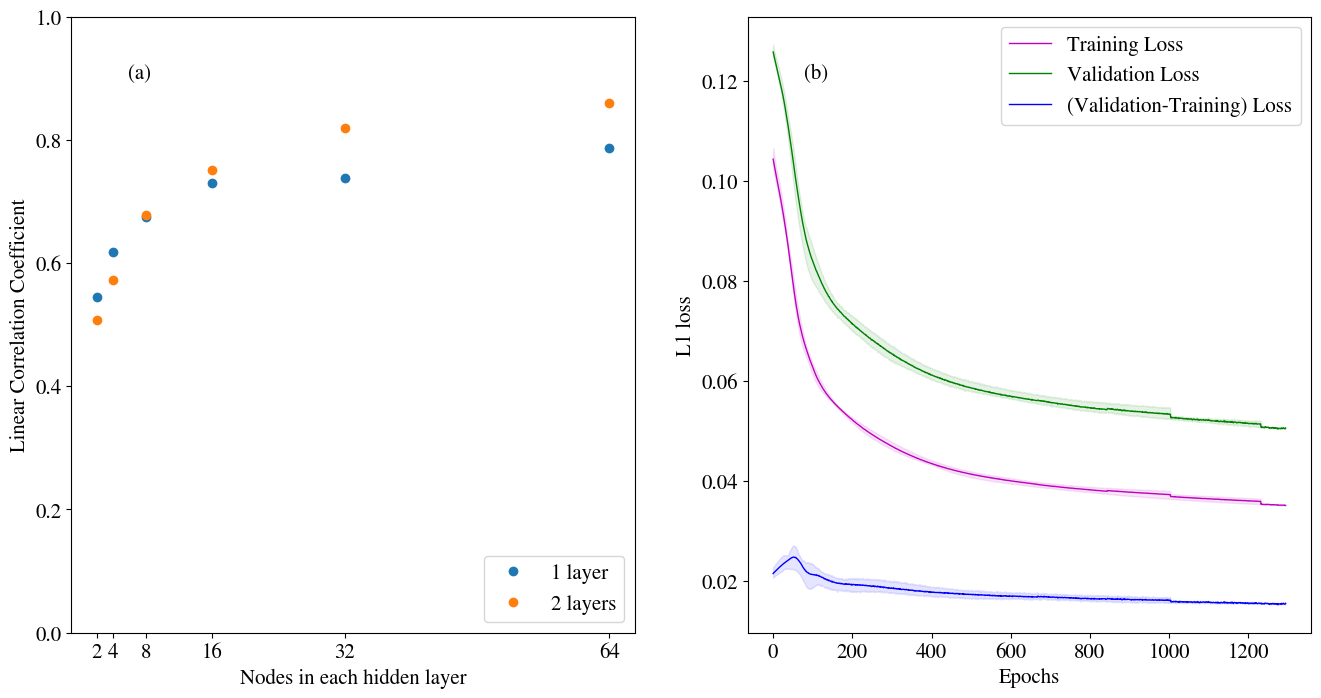

In [24]:
score_eval(hid_array, lays, valid_x, valid_y, k_mean_c, k_std_c, cwd_output)
save_losses_by_seed(os.path.join(cwd_output, 'ensemble_models_layers2_uncertainty/'), seeds)
plot_n1_scores(cwd_output, hid_array, lays, seeds, epochs=3000)

## Explanation and Discussion of Hyperparameter Sweep and Uncertainty Evaluation 
To identify the optimal hyperparameters for the model, we evaluate different configurations based on their **linear correlation coefficient** performance. The process is as follows:

- Hyperparameter Variation: We explore different numbers of hidden layers and nodes per layer. Each configuration is used to train the model, producing predictions for 16 $g(\sigma)$ points (denoted as $y$).

- Prediction Post-Processing: Each predicted $y$ is denormalized to restore its original scale. Extreme values (beyond the 5th-95th percentile) are removed to mitigate the influence of outliers, reduced the impact of noisy predictions. The Pearson correlation between the filtered predictions and the ground truth $y$ is computed.

- Final Correlation Computation: The mean correlation across all 16 $g(\sigma)$ points is taken as the final evaluation score for each hyperparameter set. This is plotted in (a). 

### Hyperparameter sweep, plot (a) 
Plot (a) shows that 2 layers with 64 nodes achieved the best performance under the linear correlation coefficient metric. 

**At 2 layers with 32 nodes, performance starts to asymptote. This is the structure selected in Sane et al. (2023) to balance skill and with computational cost.** 

Sane et al. (2023) Figure 3(a) shows a search up to 4 layers with 512 nodes. To reduce computational cost, we cut off the sweep at 2 layers with 64 nodes.

### L1 loss with uncertainty, plot (b)
Plot (b), for 2 layers with 32 nodes, we make an addition to Sane et al. (2023) by estimating uncertainty in model predictions by training with different random seeds. This captures variations in initialization. 

We use 5 random seeds to balance computational efficiency and result reliability. Increasing the number of seeds would provide a more robust estimation of uncertainty.

In [21]:
#!/usr/bin/env python
# coding: utf-8

# # Simplified Conditional Neural Network Approach for Ocean Mixing
# 
# Based on Sane et al. (2023): "Parameterizing vertical mixing coefficients in the ocean surface boundary layer using neural networks"

import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import copy
from tqdm import tqdm

# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ---------------------------------
# 1. Function to perform K-means clustering on the training data
# ---------------------------------

def create_clusters(data_load, n_clusters=4):
    """
    Cluster the training data based on input parameters (f, B0, u*, h).
    
    Parameters:
        data_load: Raw data with input parameters in first 4 columns
        n_clusters: Number of clusters
    
    Returns:
        cluster_assignments: Cluster labels for each data point
        kmeans: Trained KMeans model
        scaler: StandardScaler for preprocessing
    """
    # Extract input features for clustering
    features = data_load[:, :4]  # f, B0, u*, h
    
    # Standardize features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    
    # Apply K-means clustering
    print(f"Performing K-means clustering with {n_clusters} clusters...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_assignments = kmeans.fit_predict(scaled_features)
    
    # Print cluster sizes
    for i in range(n_clusters):
        count = np.sum(cluster_assignments == i)
        print(f"Cluster {i}: {count} samples ({count/len(cluster_assignments)*100:.2f}%)")
    
    return cluster_assignments, kmeans, scaler

# ---------------------------------
# 2. Function to visualize clusters
# ---------------------------------

def plot_clusters(data_load, cluster_assignments, n_clusters):
    """
    Plot clusters and their characteristics.
    
    Parameters:
        data_load: Raw data
        cluster_assignments: Cluster labels
        n_clusters: Number of clusters
    """
    # Extract input parameters
    f = data_load[:, 0]      # Coriolis parameter
    B0 = data_load[:, 1]     # Surface Buoyancy Flux
    ustar = data_load[:, 2]  # Surface Friction Velocity
    h = data_load[:, 3]      # Boundary Layer Depth
    
    # Create scatter plots of features colored by cluster
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    
    # Plot f vs B0
    for i in range(n_clusters):
        mask = cluster_assignments == i
        axs[0, 0].scatter(f[mask], B0[mask], label=f'Cluster {i}', alpha=0.6)
    axs[0, 0].set_xlabel('Coriolis parameter (f)')
    axs[0, 0].set_ylabel('Surface Buoyancy Flux (B0)')
    axs[0, 0].set_title('f vs B0')
    axs[0, 0].legend()
    axs[0, 0].grid(True, alpha=0.3)
    
    # Plot f vs ustar
    for i in range(n_clusters):
        mask = cluster_assignments == i
        axs[0, 1].scatter(f[mask], ustar[mask], label=f'Cluster {i}', alpha=0.6)
    axs[0, 1].set_xlabel('Coriolis parameter (f)')
    axs[0, 1].set_ylabel('Surface Friction Velocity (ustar)')
    axs[0, 1].set_title('f vs ustar')
    axs[0, 1].legend()
    axs[0, 1].grid(True, alpha=0.3)
    
    # Plot B0 vs h
    for i in range(n_clusters):
        mask = cluster_assignments == i
        axs[1, 0].scatter(B0[mask], h[mask], label=f'Cluster {i}', alpha=0.6)
    axs[1, 0].set_xlabel('Surface Buoyancy Flux (B0)')
    axs[1, 0].set_ylabel('Boundary Layer Depth (h)')
    axs[1, 0].set_title('B0 vs h')
    axs[1, 0].legend()
    axs[1, 0].grid(True, alpha=0.3)
    
    # Plot ustar vs h
    for i in range(n_clusters):
        mask = cluster_assignments == i
        axs[1, 1].scatter(ustar[mask], h[mask], label=f'Cluster {i}', alpha=0.6)
    axs[1, 1].set_xlabel('Surface Friction Velocity (ustar)')
    axs[1, 1].set_ylabel('Boundary Layer Depth (h)')
    axs[1, 1].set_title('ustar vs h')
    axs[1, 1].legend()
    axs[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Plot average shape functions for each cluster
    plt.figure(figsize=(12, 6))
    
    for i in range(n_clusters):
        mask = cluster_assignments == i
        shape_functions = data_load[mask, 4:20]  # Shape function values
        
        # Calculate mean shape function
        mean_shape = np.mean(shape_functions, axis=0)
        mean_shape_norm = mean_shape / np.max(mean_shape)
        
        plt.plot(np.linspace(0, 1, 16), mean_shape_norm, linewidth=2, 
                 label=f'Cluster {i} (n={np.sum(mask)})')
    
    plt.title('Mean Shape Functions by Cluster')
    plt.xlabel('σ (normalized depth)')
    plt.ylabel('g(σ) (normalized diffusivity)')
    plt.grid(True)
    plt.legend()
    plt.show()

# ---------------------------------
# 3. Function to train models for each cluster
# ---------------------------------

def train_cluster_models(x, y, valid_x, valid_y, cluster_assignments, k_mean, k_std, n_clusters):
    """
    Train separate neural network models for each cluster.
    
    Parameters:
        x, y: Preprocessed training data
        valid_x, valid_y: Validation data
        cluster_assignments: Cluster labels
        k_mean, k_std: Normalization parameters
        n_clusters: Number of clusters
    
    Returns:
        models: Dictionary of trained models
    """
    # Setup 
    k_mean_c = torch.tensor(k_mean).float().to(device)
    k_std_c = torch.tensor(k_std).float().to(device)
    
    # Weight mask (same as in original code)
    kmask = np.ones(16)
    
    # Parameters
    epochs, lr = 3000, 1e-03
    in_nod, hid_nod, o_nod = 4, 32, 16
    
    # Dictionary to store models
    models = {}
    
    # First train a baseline model using all data
    print("Training baseline model on all data...")
    torch.manual_seed(10)
    baseline_model = learnKappa_layers(in_nod, hid_nod, o_nod)
    baseline_model = baseline_model.to(device)
    
    baseline_model, baseline_loss = modeltrain_loss(
        in_nod, hid_nod, o_nod, lr, epochs, 
        x, y, valid_x, valid_y, baseline_model, 
        torch.tensor(kmask).float().to(device), k_mean_c, k_std_c
    )
    
    models['baseline'] = baseline_model
    
    # Train a model for each cluster
    for cluster_id in range(n_clusters):
        # Get indices for this cluster
        cluster_indices = np.where(cluster_assignments == cluster_id)[0]
        
        if len(cluster_indices) < 50:
            print(f"Warning: Cluster {cluster_id} has only {len(cluster_indices)} samples. Using baseline model instead.")
            models[cluster_id] = baseline_model
            continue
        
        print(f"Training model for Cluster {cluster_id} with {len(cluster_indices)} samples...")
        
        # Extract training data for this cluster
        x_cluster = x[cluster_indices]
        y_cluster = y[cluster_indices]
        
        # Initialize model
        torch.manual_seed(10 + cluster_id)
        model = learnKappa_layers(in_nod, hid_nod, o_nod)
        model = model.to(device)
        
        # Train model
        model, _ = modeltrain_loss(
            in_nod, hid_nod, o_nod, lr, epochs, 
            x_cluster, y_cluster, valid_x, valid_y, model, 
            torch.tensor(kmask).float().to(device), k_mean_c, k_std_c
        )
        
        models[cluster_id] = model
    
    return models

# Modified training function for individual cluster training
def modeltrain_loss(In_nodes, Hid, Out_nodes, lr, epochs, x, y, valid_x, valid_y, model, k_std_y, k_mean, k_std, patience=20):
    """Training function for neural networks (adapted from original code)"""
    optimizer = torch.optim.Adam(model.parameters(), lr)
    loss_fn = torch.nn.L1Loss(reduction='mean')
    loss_array = torch.zeros([epochs, 3])

    best_loss = float('inf')
    no_improvement = 0
    best_model_state = None

    with tqdm(total=epochs, unit="epoch") as pbar:
        for k in range(epochs):
            optimizer.zero_grad()
            y_pred = model(x)
            
            valid_pred = model(valid_x)
            
            loss = loss_fn(y_pred * k_std_y, y * k_std_y)
            
            loss_train = torch.mean(torch.abs(torch.exp(y_pred * k_std + k_mean) - torch.exp(y * k_std + k_mean)))
            loss_valid = torch.mean(torch.abs(torch.exp(valid_pred * k_std + k_mean) - torch.exp(valid_y * k_std + k_mean)))
            
            loss.backward()
            optimizer.step()

            loss_array[k, 0] = k  
            loss_array[k, 1] = loss_train.item()  
            loss_array[k, 2] = loss_valid.item()  

            pbar.set_postfix(
                train_loss=loss_train.item(), 
                valid_loss=loss_valid.item(), 
                patience=no_improvement
            )
            pbar.update(1)

            if loss_valid.item() < best_loss:
                best_loss = loss_valid.item()
                no_improvement = 0
                best_model_state = model.state_dict()
            else:
                no_improvement += 1

            if no_improvement >= patience:
                print(f"Early stopping at epoch {k+1}. No improvement for {patience} epochs.")
                break

            del loss, y_pred
            
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return model, loss_array[:k+1, :]

# ---------------------------------
# 4. Function to assign clusters and make predictions
# ---------------------------------

def predict_with_cluster_models(x_input, models, kmeans, scaler, k_mean, k_std):
    """
    Make predictions using cluster-specific models.
    
    Parameters:
        x_input: Input data (validation data)
        models: Dictionary of trained models
        kmeans: Trained KMeans model
        scaler: StandardScaler used for clustering
        k_mean, k_std: Normalization parameters
    
    Returns:
        Predictions from cluster-specific models
    """
    # Convert to numpy if it's a tensor
    if isinstance(x_input, torch.Tensor):
        x_np = x_input.cpu().numpy()
    else:
        x_np = x_input
    
    # Scale input features
    x_scaled = scaler.transform(x_np)
    
    # Assign clusters
    cluster_assignments = kmeans.predict(x_scaled)
    
    # Make predictions
    predictions = []
    
    for i, cluster_id in enumerate(cluster_assignments):
        # Use the model for this cluster
        if cluster_id in models:
            model = models[cluster_id]
        else:
            # Fall back to baseline if cluster has no model
            model = models['baseline']
        
        # Get input as tensor
        if isinstance(x_input, torch.Tensor):
            x_i = x_input[i:i+1]
        else:
            x_i = torch.tensor(x_np[i:i+1], dtype=torch.float32).to(device)
        
        # Make prediction
        with torch.no_grad():
            pred = model(x_i)
            # Denormalize the prediction
            pred_denorm = torch.exp(pred * torch.tensor(k_std).to(device) + 
                                  torch.tensor(k_mean).to(device))
            predictions.append(pred_denorm)
    
    return torch.cat(predictions, dim=0)

# ---------------------------------
# 5. Function to evaluate and compare models
# ---------------------------------

def evaluate_models(baseline_model, cluster_models, kmeans, scaler, valid_x, valid_y, k_mean, k_std):
    """
    Compare performance of baseline model vs cluster-based models.
    
    Parameters:
        baseline_model: Model trained on all data
        cluster_models: Dictionary of models trained on clusters
        kmeans, scaler: For cluster assignment
        valid_x, valid_y: Validation data
        k_mean, k_std: Normalization parameters
    """
    # Predict with baseline model
    with torch.no_grad():
        y_pred_baseline = baseline_model(valid_x)
        baseline_pred = torch.exp(y_pred_baseline * torch.tensor(k_std).to(device) + 
                                torch.tensor(k_mean).to(device))
        
        baseline_loss = torch.mean(torch.abs(baseline_pred - 
                                           torch.exp(valid_y * torch.tensor(k_std).to(device) + 
                                                   torch.tensor(k_mean).to(device))))
    
    # Predict with cluster models
    cluster_pred = predict_with_cluster_models(valid_x, cluster_models, kmeans, scaler, k_mean, k_std)
    
    with torch.no_grad():
        cluster_loss = torch.mean(torch.abs(cluster_pred - 
                                          torch.exp(valid_y * torch.tensor(k_std).to(device) + 
                                                  torch.tensor(k_mean).to(device))))
    
    print(f"Baseline Model Validation Loss: {baseline_loss.item():.6f}")
    print(f"Cluster-based Models Validation Loss: {cluster_loss.item():.6f}")
    
    # Calculate improvement
    improvement = (baseline_loss.item() - cluster_loss.item()) / baseline_loss.item() * 100
    print(f"Improvement: {improvement:.2f}%")
    
    # Calculate node-by-node losses
    node_losses_baseline = []
    node_losses_cluster = []
    
    for i in range(16):  # For each output node
        with torch.no_grad():
            # True values
            true_values = torch.exp(valid_y[:, i] * k_std[i] + k_mean[i])
            
            # Baseline model node loss
            node_loss_baseline = torch.mean(torch.abs(baseline_pred[:, i] - true_values))
            
            # Cluster model node loss
            node_loss_cluster = torch.mean(torch.abs(cluster_pred[:, i] - true_values))
            
            node_losses_baseline.append(node_loss_baseline.item())
            node_losses_cluster.append(node_loss_cluster.item())
    
    # Plot node-by-node comparison
    plt.figure(figsize=(10, 6))
    nodes = range(1, 17)
    width = 0.35
    
    plt.bar([n - width/2 for n in nodes], node_losses_baseline, width, label='Baseline Model')
    plt.bar([n + width/2 for n in nodes], node_losses_cluster, width, label='Cluster Models')
    
    plt.xlabel('Node (σ position)')
    plt.ylabel('L1 Loss')
    plt.title('Node-by-node Loss Comparison')
    plt.xticks(nodes)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Visualize predictions for a few random samples
    sample_indices = np.random.choice(len(valid_x), size=4, replace=False)
    
    plt.figure(figsize=(14, 8))
    for i, idx in enumerate(sample_indices):
        plt.subplot(2, 2, i+1)
        
        # Get predictions
        with torch.no_grad():
            baseline_vals = baseline_pred[idx].cpu().numpy()
            cluster_vals = cluster_pred[idx].cpu().numpy()
            true_vals = torch.exp(valid_y[idx] * torch.tensor(k_std).to(device) + 
                               torch.tensor(k_mean).to(device)).cpu().numpy()
        
        # Normalize for visualization
        baseline_norm = baseline_vals / np.max(baseline_vals)
        cluster_norm = cluster_vals / np.max(cluster_vals)
        true_norm = true_vals / np.max(true_vals)
        
        # Plot
        sigma = np.linspace(0, 1, 16)
        plt.plot(sigma, true_norm, 'ko-', label='True')
        plt.plot(sigma, baseline_norm, 'b--', label='Baseline')
        plt.plot(sigma, cluster_norm, 'r-.', label='Cluster')
        
        plt.title(f'Sample {i+1}')
        plt.xlabel('σ (normalized depth)')
        plt.ylabel('g(σ) (normalized)')
        plt.grid(True)
        plt.legend()
    
    plt.tight_layout()
    plt.show()

# ---------------------------------
# 6. Main function to run the complete analysis
# ---------------------------------

def run_clustering_analysis(data_load, x, y, valid_x, valid_y, k_mean, k_std, n_clusters=4):
    """
    Main function to run the complete clustering and model training process.
    
    Parameters:
        data_load: Raw data
        x, y: Preprocessed training data
        valid_x, valid_y: Validation data
        k_mean, k_std: Normalization parameters
        n_clusters: Number of clusters
        
    Returns:
        Dictionary of results
    """
    # 1. Create clusters
    cluster_assignments, kmeans, scaler = create_clusters(data_load, n_clusters)
    
    # 2. Visualize clusters
    plot_clusters(data_load, cluster_assignments, n_clusters)
    
    # 3. Train models for each cluster
    cluster_models = train_cluster_models(x, y, valid_x, valid_y, cluster_assignments, k_mean, k_std, n_clusters)
    
    # 4. Evaluate and compare models
    evaluate_models(cluster_models['baseline'], cluster_models, kmeans, scaler, valid_x, valid_y, k_mean, k_std)
    
    # 5. Return results
    return {
        'cluster_assignments': cluster_assignments,
        'kmeans': kmeans,
        'scaler': scaler,
        'models': cluster_models
    }

# Example usage in the notebook:
#
# # Load and preprocess data as in the original code
# data_load3 = copy.deepcopy(data_load_main)
# data, x, y, stats, k_mean, k_std = ff.preprocess_train_data(data_load3)
# 
# # Convert to tensors
# x = torch.FloatTensor(x).to(device)
# y = torch.FloatTensor(y).to(device)
# valid_x = torch.FloatTensor(valid_x).to(device)
# valid_y = torch.FloatTensor(valid_y).to(device)
# 
# # Run the clustering analysis with 4 clusters
# results = run_clustering_analysis(data_load3, x, y, valid_x, valid_y, k_mean, k_std, n_clusters=4)

Using device: cuda


In [27]:
# need to clean up above!

def ensure_tensor(x, device):
    """
    Ensure x is a tensor on the specified device.
    
    Parameters:
        x: Input data (numpy array or tensor)
        device: Device to place tensor on
        
    Returns:
        Tensor on the specified device
    """
    if isinstance(x, torch.Tensor):
        return x.to(device)
    else:
        return torch.FloatTensor(x).to(device)

def predict_with_cluster_models(x_input, models, kmeans, scaler, k_mean, k_std):
    """
    Make predictions using cluster-specific models.
    
    Parameters:
        x_input: Input data (validation data)
        models: Dictionary of trained models
        kmeans: Trained KMeans model
        scaler: StandardScaler used for clustering
        k_mean, k_std: Normalization parameters
    
    Returns:
        Predictions from cluster-specific models
    """
    # Convert to numpy if it's a tensor
    if isinstance(x_input, torch.Tensor):
        x_np = x_input.cpu().numpy()
    else:
        x_np = x_input
    
    # Ensure the numpy array has the correct data type
    x_np = x_np.astype(np.float64)  # Use float64 (double) for consistency with KMeans
    
    # Scale input features
    x_scaled = scaler.transform(x_np)
    
    # Assign clusters
    cluster_assignments = kmeans.predict(x_scaled)
    
    # Make predictions
    predictions = []
    
    for i, cluster_id in enumerate(cluster_assignments):
        # Use the model for this cluster
        if cluster_id in models:
            model = models[cluster_id]
        else:
            # Fall back to baseline if cluster has no model
            model = models['baseline']
        
        # Get input as tensor
        if isinstance(x_input, torch.Tensor):
            x_i = x_input[i:i+1]
        else:
            x_i = torch.tensor(x_np[i:i+1], dtype=torch.float32).to(device)
        
        # Make prediction
        with torch.no_grad():
            pred = model(x_i)
            # Denormalize the prediction
            pred_denorm = torch.exp(pred * torch.tensor(k_std).to(device) + 
                                  torch.tensor(k_mean).to(device))
            predictions.append(pred_denorm)
    
    return torch.cat(predictions, dim=0)

def create_clusters(data_load, n_clusters=4):
    """
    Cluster the training data based on input parameters (f, B0, u*, h).
    
    Parameters:
        data_load: Raw data with input parameters in first 4 columns
        n_clusters: Number of clusters
    
    Returns:
        cluster_assignments: Cluster labels for each data point
        kmeans: Trained KMeans model
        scaler: StandardScaler for preprocessing
    """
    # Extract input features for clustering
    features = data_load[:, :4].astype(np.float64)  # f, B0, u*, h - ensure float64
    
    # Standardize features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    
    # Apply K-means clustering
    print(f"Performing K-means clustering with {n_clusters} clusters...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_assignments = kmeans.fit_predict(scaled_features)
    
    # Print cluster sizes
    for i in range(n_clusters):
        count = np.sum(cluster_assignments == i)
        print(f"Cluster {i}: {count} samples ({count/len(cluster_assignments)*100:.2f}%)")
    
    return cluster_assignments, kmeans, scaler

In [29]:
# Improved plotting functions for the ocean mixing clustering project

def plot_clusters(data_load, cluster_assignments, n_clusters):
    """
    Plot clusters and their characteristics with improved visualizations.
    
    Parameters:
        data_load: Raw data
        cluster_assignments: Cluster labels
        n_clusters: Number of clusters
    """
    # Extract input parameters
    f = data_load[:, 0]      # Coriolis parameter
    B0 = data_load[:, 1]     # Surface Buoyancy Flux
    ustar = data_load[:, 2]  # Surface Friction Velocity
    h = data_load[:, 3]      # Boundary Layer Depth
    
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Set better plotting parameters
    plt.rcParams['font.size'] = 12
    plt.rcParams['axes.labelsize'] = 14
    plt.rcParams['axes.titlesize'] = 16
    plt.rcParams['legend.fontsize'] = 12
    
    # Create a more focused plot for input parameters
    fig, axs = plt.subplots(2, 2, figsize=(14, 12))
    
    # Define colors for each cluster
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']
    
    # Plot f vs B0 with better visualization
    axs[0, 0].set_title('Clusters: Coriolis vs Surface Buoyancy Flux')
    for i in range(n_clusters):
        mask = cluster_assignments == i
        axs[0, 0].scatter(f[mask], B0[mask], color=colors[i % len(colors)], 
                          label=f'Cluster {i}', alpha=0.7, s=20, edgecolor='none')
    axs[0, 0].set_xlabel('Coriolis parameter (f) [s$^{-1}$]')
    axs[0, 0].set_ylabel('Surface Buoyancy Flux (B0) [m$^2$/s$^3$]')
    axs[0, 0].grid(True, linestyle='--', alpha=0.7)
    axs[0, 0].legend(loc='best')
    
    # Plot ustar distribution by cluster
    axs[0, 1].set_title('Surface Friction Velocity by Cluster')
    for i in range(n_clusters):
        mask = cluster_assignments == i
        axs[0, 1].hist(ustar[mask], bins=30, alpha=0.7, label=f'Cluster {i}',
                       color=colors[i % len(colors)], density=True)
    axs[0, 1].set_xlabel('Surface Friction Velocity (ustar) [m/s]')
    axs[0, 1].set_ylabel('Density')
    axs[0, 1].grid(True, linestyle='--', alpha=0.7)
    axs[0, 1].legend(loc='best')
    
    # Plot h distribution by cluster
    axs[1, 0].set_title('Boundary Layer Depth by Cluster')
    for i in range(n_clusters):
        mask = cluster_assignments == i
        axs[1, 0].hist(h[mask], bins=30, alpha=0.7, label=f'Cluster {i}',
                      color=colors[i % len(colors)], density=True)
    axs[1, 0].set_xlabel('Boundary Layer Depth (h) [m]')
    axs[1, 0].set_ylabel('Density')
    axs[1, 0].grid(True, linestyle='--', alpha=0.7)
    axs[1, 0].legend(loc='best')
    
    # Plot B0 distribution by cluster
    axs[1, 1].set_title('Surface Buoyancy Flux by Cluster')
    for i in range(n_clusters):
        mask = cluster_assignments == i
        axs[1, 1].hist(B0[mask], bins=30, alpha=0.7, label=f'Cluster {i}',
                      color=colors[i % len(colors)], density=True)
    axs[1, 1].set_xlabel('Surface Buoyancy Flux (B0) [m$^2$/s$^3$]')
    axs[1, 1].set_ylabel('Density')
    axs[1, 1].grid(True, linestyle='--', alpha=0.7)
    axs[1, 1].legend(loc='best')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate cluster statistics for informative display
    df = pd.DataFrame({
        'f': f,
        'B0': B0,
        'ustar': ustar,
        'h': h,
        'cluster': cluster_assignments
    })
    
    cluster_stats = df.groupby('cluster').agg(['mean', 'std', 'min', 'max'])
    print("\nCluster Statistics (means):")
    print(cluster_stats.xs('mean', level=1, axis=1))
    
    # Plot shape functions similar to the paper style
    plt.figure(figsize=(8, 10))
    sig = np.linspace(0, 1, 18)  # 18 points including 0 and 1
    
    # Array to collect mean shape functions for each cluster
    mean_shape_functions = np.zeros((n_clusters, 16))
    std_shape_functions = np.zeros((n_clusters, 16))
    
    # Create a similar style to Figure 1 from the paper
    for i in range(n_clusters):
        mask = cluster_assignments == i
        shape_functions = data_load[mask, 4:20]  # Shape function values
        
        # Calculate mean and standard deviation
        mean_shape = np.mean(shape_functions, axis=0)
        std_shape = np.std(shape_functions, axis=0)
        
        # Normalize to [0,1]
        mean_shape_norm = mean_shape / np.max(mean_shape)
        mean_shape_functions[i] = mean_shape_norm
        
        # Calculate normalized std dev
        std_shape_norm = std_shape / np.max(mean_shape)
        std_shape_functions[i] = std_shape_norm
        
        # Calculate min and max for fill_between
        shape_min = mean_shape_norm - std_shape_norm
        shape_min = np.maximum(shape_min, 0)  # Ensure non-negative
        shape_max = mean_shape_norm + std_shape_norm
    
    # Plot similar to paper figure
    # First, create sigma values including 0 and 1
    sigma_full = np.linspace(0, 1, 18)
    
    # For each cluster, plot the mean and shaded region
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    
    # Universal shape function as in the paper
    z = np.linspace(0, 1, 100)
    z1 = z * (1-z)**2
    z1 = z1 / np.max(z1)
    
    plt.plot(z1[::-1], z, color='brown', linestyle='--', 
             label='Universal shape function', linewidth=2)
    
    # Plot each cluster's shape function
    for i in range(n_clusters):
        mask = cluster_assignments == i
        shape_functions = data_load[mask, 4:20]  # Shape function values
        
        # Calculate statistics
        mean_shape = np.mean(shape_functions, axis=0)
        std_shape = np.std(shape_functions, axis=0)
        
        # Normalize
        mean_shape_norm = mean_shape / np.max(mean_shape)
        std_shape_norm = std_shape / np.max(mean_shape)
        
        # Add zeros at beginning and end
        mean_full = np.zeros(18)
        mean_full[1:17] = mean_shape_norm
        
        std_full = np.zeros(18)
        std_full[1:17] = std_shape_norm
        
        # Calculate min/max bounds for fill_between
        lower_bound = np.maximum(mean_full - std_full, 0)
        upper_bound = mean_full + std_full
        
        # Plot with fill_between for the distribution
        plt.fill_betweenx(sigma_full, lower_bound, upper_bound, 
                         alpha=0.2, color=colors[i % len(colors)])
        
        plt.plot(mean_full, sigma_full, color=colors[i % len(colors)], 
                 label=f'Cluster {i} (n={np.sum(mask)})', linewidth=2)
    
    plt.xlabel(r'$g(\sigma)$', fontsize=16)
    plt.ylabel(r'$\sigma$ ($\sigma$=0 is surface, $\sigma$=1 is bottom of the mixed layer)', fontsize=14)
    plt.title('Shape Functions by Cluster', fontsize=18)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

def evaluate_models(baseline_model, cluster_models, kmeans, scaler, valid_x, valid_y, k_mean, k_std):
    """
    Compare performance of baseline model vs cluster-based models with improved visualizations.
    
    Parameters:
        baseline_model: Model trained on all data
        cluster_models: Dictionary of models trained on clusters
        kmeans, scaler: For cluster assignment
        valid_x, valid_y: Validation data
        k_mean, k_std: Normalization parameters
    """
    import torch
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.gridspec import GridSpec
    
    # Set improved plotting style
    plt.rcParams['font.size'] = 12
    plt.rcParams['axes.labelsize'] = 14
    plt.rcParams['axes.titlesize'] = 16
    plt.rcParams['legend.fontsize'] = 12
    plt.rcParams['lines.linewidth'] = 2
    
    # Get the device
    device = next(baseline_model.parameters()).device
    
    # Predict with baseline model
    with torch.no_grad():
        y_pred_baseline = baseline_model(valid_x)
        baseline_pred = torch.exp(y_pred_baseline * torch.tensor(k_std).to(device) + 
                                torch.tensor(k_mean).to(device))
        
        true_values = torch.exp(valid_y * torch.tensor(k_std).to(device) + 
                              torch.tensor(k_mean).to(device))
        
        baseline_loss = torch.mean(torch.abs(baseline_pred - true_values))
    
    # Predict with cluster models
    cluster_pred = predict_with_cluster_models(valid_x, cluster_models, kmeans, scaler, k_mean, k_std)
    
    with torch.no_grad():
        cluster_loss = torch.mean(torch.abs(cluster_pred - true_values))
    
    print(f"Baseline Model Validation Loss: {baseline_loss.item():.6f}")
    print(f"Cluster-based Models Validation Loss: {cluster_loss.item():.6f}")
    
    # Calculate improvement
    improvement = (baseline_loss.item() - cluster_loss.item()) / baseline_loss.item() * 100
    print(f"Improvement: {improvement:.2f}%")
    
    # Calculate node-by-node losses
    node_losses_baseline = []
    node_losses_cluster = []
    
    for i in range(16):  # For each output node
        with torch.no_grad():
            # True values
            true_node = torch.exp(valid_y[:, i] * k_std[i] + k_mean[i])
            
            # Baseline model node loss
            node_loss_baseline = torch.mean(torch.abs(baseline_pred[:, i] - true_node))
            
            # Cluster model node loss
            node_loss_cluster = torch.mean(torch.abs(cluster_pred[:, i] - true_node))
            
            node_losses_baseline.append(node_loss_baseline.item())
            node_losses_cluster.append(node_loss_cluster.item())
    
    # Create Fig 4-like visualization with node-wise comparisons
    fig = plt.figure(figsize=(15, 10))
    gs = GridSpec(1, 4, figure=fig, width_ratios=[1, 1, 1, 1])
    
    # Plot 1: Bar chart of node errors
    ax1 = fig.add_subplot(gs[0, 0])
    ind = np.arange(16)
    ind_tick = np.arange(1, 17)[::-1]  # Reverse order like in the paper
    
    # Error differences
    error_diff = [baseline - cluster for baseline, cluster in zip(node_losses_baseline, node_losses_cluster)]
    
    # Plot horizontal boxplot for node errors
    ax1.barh(ind, error_diff, color=['green' if x > 0 else 'red' for x in error_diff])
    ax1.set_yticks(ind)
    ax1.set_yticklabels(ind_tick)
    ax1.set_title('(a) Error reduction by node')
    ax1.set_ylabel('Node')
    ax1.set_xlabel('Baseline error - Cluster error')
    ax1.grid(axis='x', linestyle='--', alpha=0.7)
    
    # Plot 2: Barplot comparing total errors
    ax2 = fig.add_subplot(gs[0, 1])
    bar_width = 0.35
    ax2.bar(0 - bar_width/2, baseline_loss.item(), bar_width, label='Baseline Model')
    ax2.bar(0 + bar_width/2, cluster_loss.item(), bar_width, label='Cluster Models')
    ax2.set_xticks([0])
    ax2.set_xticklabels(['Models'])
    ax2.set_title('(b) Overall Loss Comparison')
    ax2.set_ylabel('L1 Loss')
    ax2.legend()
    ax2.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add percentage improvement
    ax2.text(0, baseline_loss.item() * 1.05, 
            f"{improvement:.2f}% improvement", 
            ha='center', va='bottom', fontsize=12, 
            bbox=dict(facecolor='white', alpha=0.5))
    
    # Plot 3: Example shape functions
    ax3 = fig.add_subplot(gs[0, 2])
    k12 = 15  # Top node as in the paper

    # Plot histograms similar to Fig 4c from the paper
    # Sample some validation cases
    n_samples = min(1000, valid_x.shape[0])
    sample_indices = np.random.choice(valid_x.shape[0], n_samples, replace=False)
    
    # Get specific node predictions
    with torch.no_grad():
        baseline_node = baseline_pred[sample_indices, k12].cpu().numpy()
        cluster_node = cluster_pred[sample_indices, k12].cpu().numpy()
        true_node = true_values[sample_indices, k12].cpu().numpy()
    
    # Create histogram
    hist_bins = np.linspace(0, 1.2, 30)
    ax3.hist(true_node, bins=hist_bins, alpha=0.6, color='blue', label='True')
    ax3.hist(baseline_node, bins=hist_bins, alpha=0.6, color='red', label='Baseline')
    ax3.hist(cluster_node, bins=hist_bins, alpha=0.6, color='green', label='Cluster')
    
    ax3.set_title('(c) Probability density for node 16')
    ax3.set_xlabel('g(σ) value')
    ax3.set_ylabel('Count')
    ax3.legend()
    
    # Plot 4: Error histogram (like Fig 4d)
    ax4 = fig.add_subplot(gs[0, 3])
    
    # Calculate errors
    baseline_errors = baseline_node - true_node
    cluster_errors = cluster_node - true_node
    
    # Create error histogram
    error_bins = np.linspace(-0.2, 0.2, 30)
    ax4.hist(baseline_errors, bins=error_bins, alpha=0.6, color='red', label='Baseline')
    ax4.hist(cluster_errors, bins=error_bins, alpha=0.6, color='green', label='Cluster')
    
    ax4.set_title('(d) Error histogram for node 16')
    ax4.set_xlabel('Error')
    ax4.set_ylabel('Count')
    ax4.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Create a second plot showing example shape functions (like Fig 1 in the paper)
    plt.figure(figsize=(10, 8))
    
    # Sample 5 random validation points
    sample_indices = np.random.choice(valid_x.shape[0], 5, replace=False)
    sigma = np.linspace(0, 1, 16)
    
    for i, idx in enumerate(sample_indices):
        plt.subplot(2, 3, i+1)
        
        # Get predictions for this sample
        with torch.no_grad():
            baseline_vals = baseline_pred[idx].cpu().numpy()
            cluster_vals = cluster_pred[idx].cpu().numpy()
            true_vals = true_values[idx].cpu().numpy()
        
        # Normalize for better visualization
        baseline_norm = baseline_vals / np.max(baseline_vals)
        cluster_norm = cluster_vals / np.max(cluster_vals)
        true_norm = true_vals / np.max(true_vals)
        
        # Plot with proper formatting
        plt.plot(true_norm, sigma, 'ko-', label='True')
        plt.plot(baseline_norm, sigma, 'r--', label='Baseline')
        plt.plot(cluster_norm, sigma, 'g-.', label='Cluster')
        
        plt.title(f'Sample {i+1}')
        plt.xlabel(r'$g(\sigma)$')
        plt.ylabel(r'$\sigma$')
        plt.gca().invert_yaxis()  # Invert y-axis to match paper
        plt.grid(True, linestyle='--', alpha=0.7)
        
        if i == 0:
            plt.legend()
    
    plt.tight_layout()
    plt.show()

def assign_clusters(x, cluster_centers, scaler):
    """Simple function to assign data points to clusters"""
    import numpy as np
    
    x_scaled = scaler.transform(x.astype(np.float64))
    
    # Calculate distance to each cluster center
    distances = np.zeros((x_scaled.shape[0], len(cluster_centers)))
    
    for i, center in enumerate(cluster_centers):
        distances[:, i] = np.sqrt(((x_scaled - center) ** 2).sum(axis=1))
    
    # Assign to nearest cluster
    return np.argmin(distances, axis=1)

def predict_with_cluster_models(x_input, models, kmeans, scaler, k_mean, k_std):
    """
    Make predictions using cluster-specific models.
    
    Parameters:
        x_input: Input data (validation data)
        models: Dictionary of trained models
        kmeans: Trained KMeans model
        scaler: StandardScaler used for clustering
        k_mean, k_std: Normalization parameters
    
    Returns:
        Predictions from cluster-specific models
    """
    import numpy as np
    import torch
    
    # Get the device
    device = next(iter(models.values())).parameters().__next__().device
    
    # Convert to numpy if it's a tensor
    if isinstance(x_input, torch.Tensor):
        x_np = x_input.cpu().numpy()
    else:
        x_np = x_input
    
    # Ensure the numpy array has the correct data type
    x_np = x_np.astype(np.float64)  # Use float64 (double) for consistency with KMeans
    
    # Use our custom assign_clusters function instead of kmeans.predict
    cluster_assignments = assign_clusters(x_np, kmeans.cluster_centers_, scaler)
    
    # Make predictions
    predictions = []
    
    for i, cluster_id in enumerate(cluster_assignments):
        # Use the model for this cluster
        if cluster_id in models:
            model = models[cluster_id]
        else:
            # Fall back to baseline if cluster has no model
            model = models['baseline']
        
        # Get input as tensor
        if isinstance(x_input, torch.Tensor):
            x_i = x_input[i:i+1]
        else:
            x_i = torch.tensor(x_np[i:i+1], dtype=torch.float32).to(device)
        
        # Make prediction
        with torch.no_grad():
            pred = model(x_i)
            # Denormalize the prediction
            pred_denorm = torch.exp(pred * torch.tensor(k_std).to(device) + 
                                  torch.tensor(k_mean).to(device))
            predictions.append(pred_denorm)
    
    return torch.cat(predictions, dim=0)

Performing K-means clustering with 4 clusters...
Cluster 0: 228400 samples (24.88%)
Cluster 1: 87582 samples (9.54%)
Cluster 2: 242490 samples (26.42%)
Cluster 3: 359386 samples (39.15%)


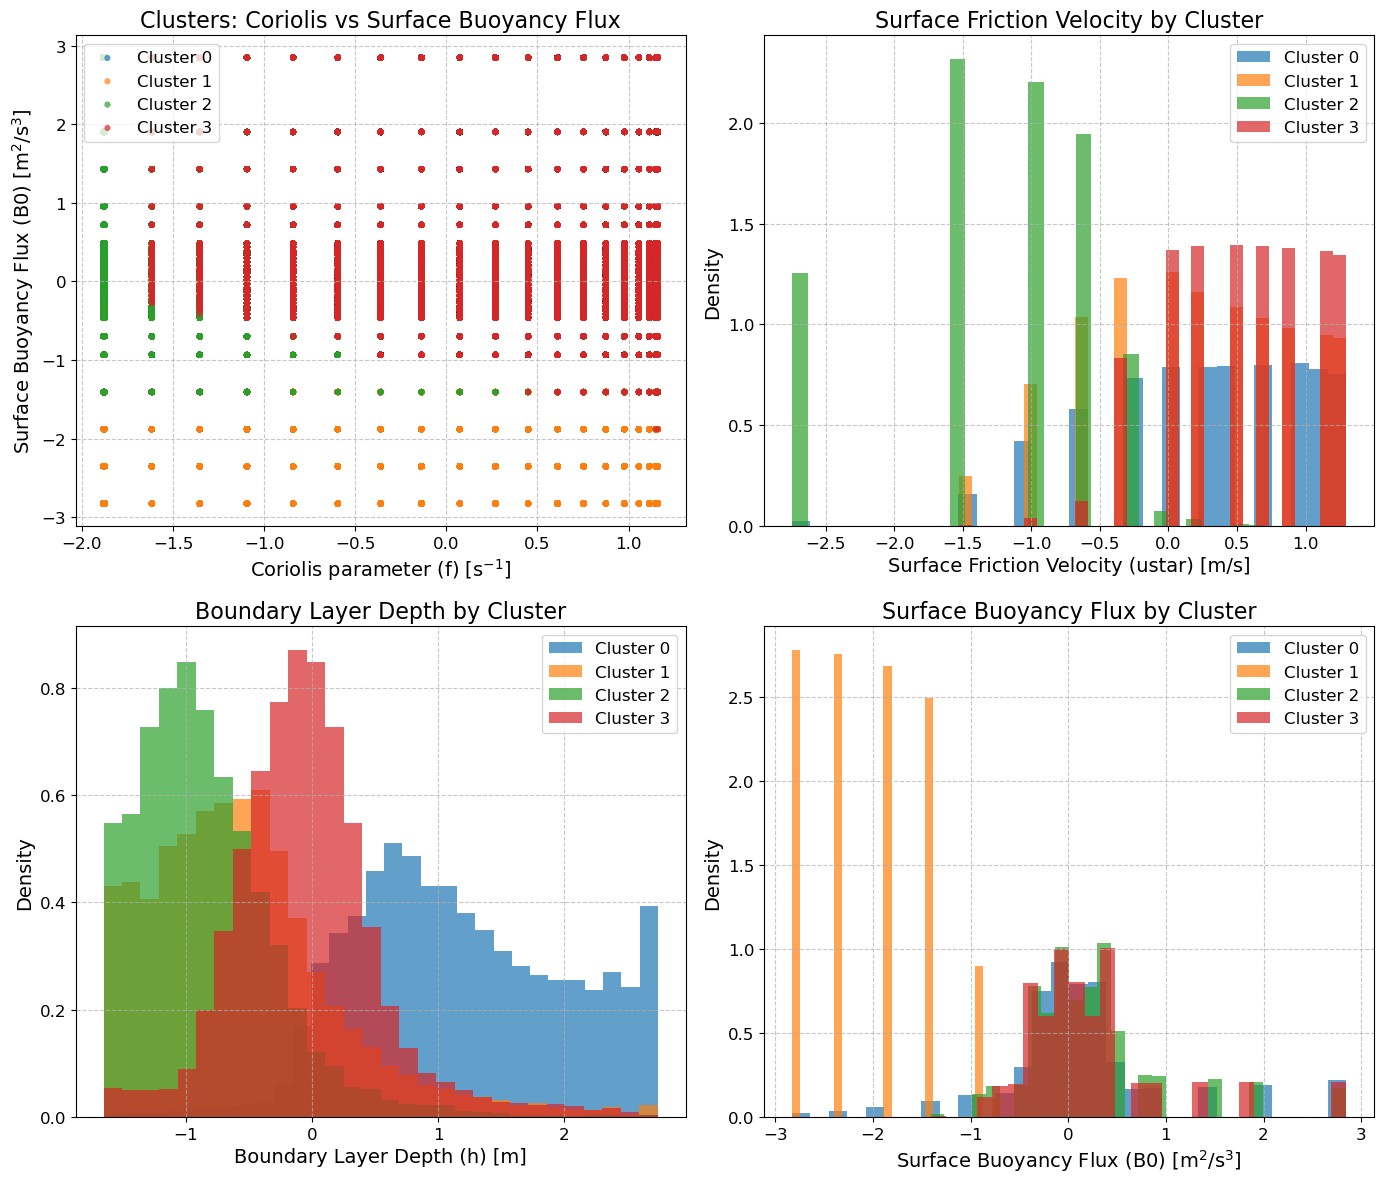


Cluster Statistics (means):
                f        B0     ustar         h
cluster                                        
0       -1.160888  0.184550  0.319155  1.178281
1        0.123339 -2.029274  0.236654 -0.546336
2        0.066217  0.221231 -1.234015 -0.844292
3        0.663041  0.227973  0.572128 -0.046017


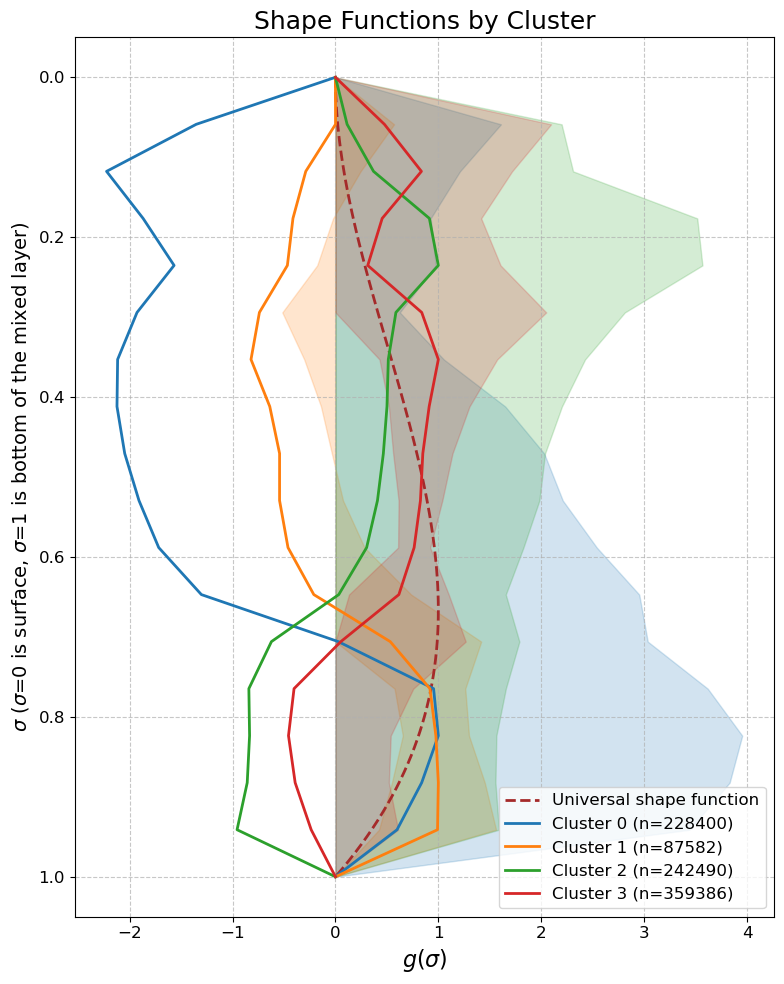

Training baseline model on all data...


 26%|██▌       | 767/3000 [00:25<01:15, 29.56epoch/s, patience=19, train_loss=0.0387, valid_loss=0.0557]


Early stopping at epoch 767. No improvement for 20 epochs.
Training model for Cluster 0 with 228400 samples...


 27%|██▋       | 818/3000 [00:08<00:23, 94.67epoch/s, patience=19, train_loss=0.0384, valid_loss=0.0554]


Early stopping at epoch 818. No improvement for 20 epochs.
Training model for Cluster 1 with 87582 samples...


 38%|███▊      | 1144/3000 [00:06<00:10, 173.53epoch/s, patience=19, train_loss=0.0366, valid_loss=0.0518]


Early stopping at epoch 1144. No improvement for 20 epochs.
Training model for Cluster 2 with 242490 samples...


 37%|███▋      | 1113/3000 [00:12<00:20, 90.15epoch/s, patience=19, train_loss=0.0356, valid_loss=0.0515]


Early stopping at epoch 1113. No improvement for 20 epochs.
Training model for Cluster 3 with 359386 samples...


 34%|███▍      | 1034/3000 [00:15<00:29, 66.58epoch/s, patience=19, train_loss=0.0368, valid_loss=0.0525]


Early stopping at epoch 1034. No improvement for 20 epochs.
Baseline Model Validation Loss: 0.055598
Cluster-based Models Validation Loss: 0.051380
Improvement: 7.59%


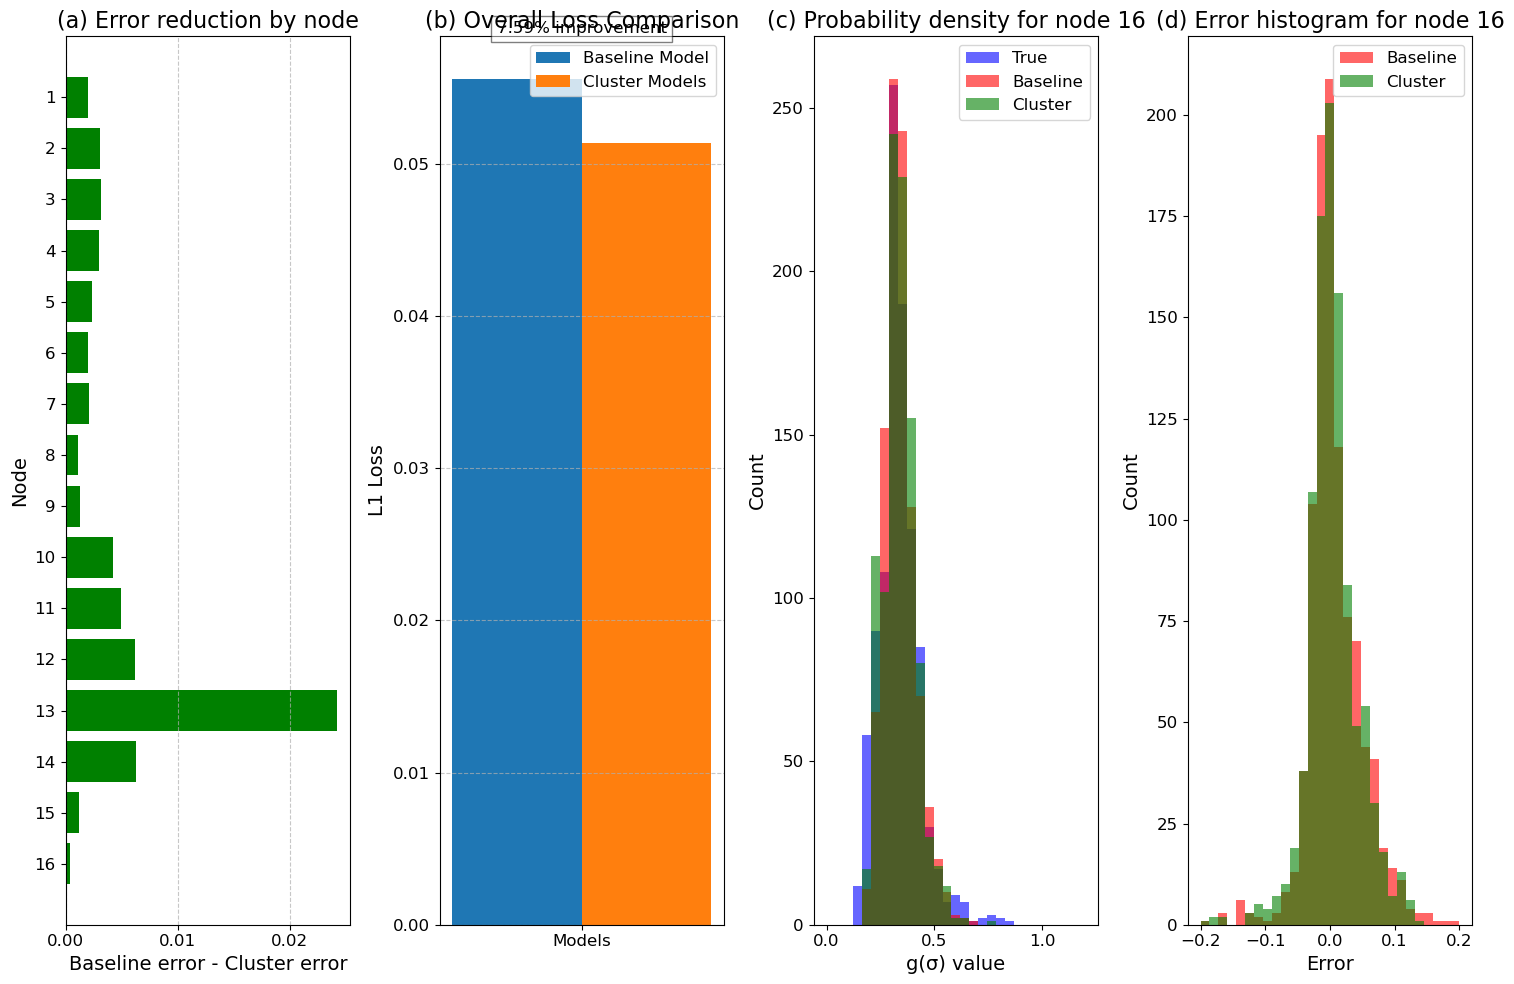

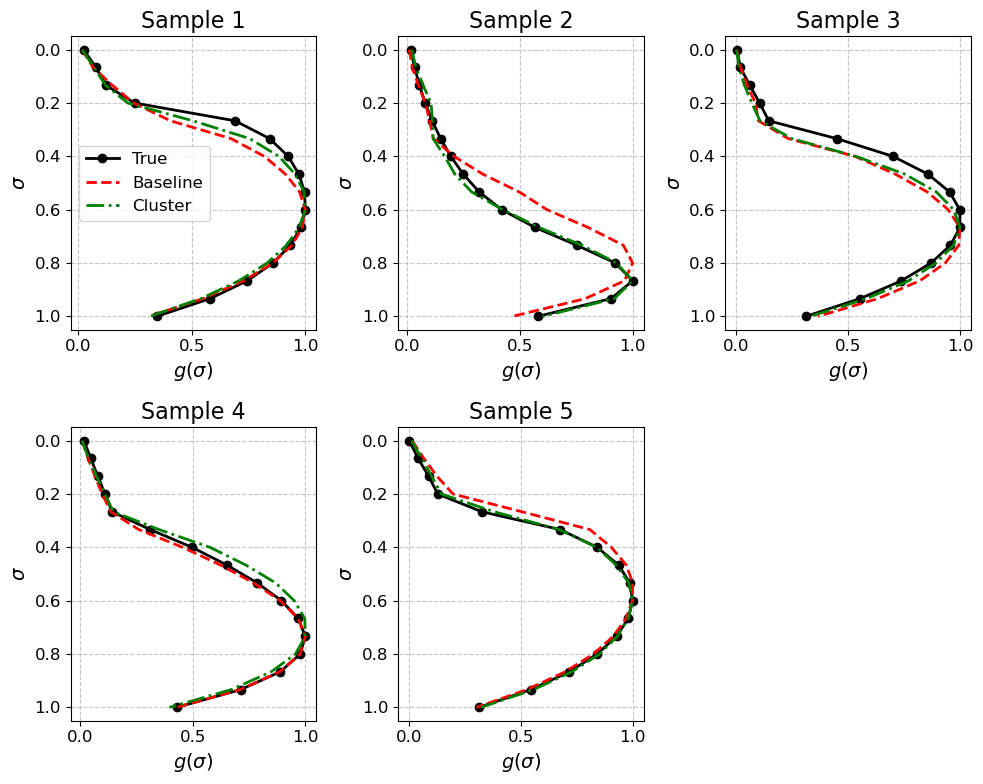

In [30]:

# Load and preprocess data as in the original code
data_load3 = copy.deepcopy(data_load_main)
data, x, y, stats, k_mean, k_std = ff.preprocess_train_data(data_load3)

# Convert to tensors safely
x = ensure_tensor(x, device)
y = ensure_tensor(y, device)
valid_x = ensure_tensor(valid_x, device)
valid_y = ensure_tensor(valid_y, device)

# Run the clustering analysis with 4 clusters
results = run_clustering_analysis(data_load3, x, y, valid_x, valid_y, k_mean, k_std, n_clusters=4)